# Final Project

### Team: Jitendra Kumar Mishra & Denvir Gamma & Erik Pak

## Overview
 - This is data set from kaggle for Heart Attack Analysis and Prediction Dataset
 - Data file used for Analysis: Heart_Attack_Data.csv
 - Link : https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

This dataset contains various features related to individuals, such as age, gender, cholesterol levels, blood pressure, and other health-related attributes. The goal of the dataset is to analyze and predict the likelihood of a heart attack occurrence based on these factors.

As per of our analysis here we will try to find a models predictive power of patient having chances of having a heart attack or not using various techniques of machine learning.

## Data Desription

The Data consists of below described variables

1. Age : Age of the patient
2. Sex : Sex of the patient (sex = 1 is male) 
3. exng: exercise induced angina (1 = yes; 0 = no)
4. caa: number of major vessels (0-3)
    - Value 0: Unknown
    - Value 1: Fixed Defect
    - Value 2: Normal
    - Value 3: Reversable Defect
5. cp : Chest Pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
6. trtbps : resting blood pressure (in mm Hg)
7. chol : cholesterol in mg/dl fetched via BMI sensor
8. fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
9. restecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
10. thalachh : maximum heart rate achieved
11. oldpeak : ST depression induced by exercise relative to rest
12. thall : Thalassemia
    - Value 0: Unknown
    - Value 1: Fixed Defect
    - Value 2: Normal
    - Value 3: Reversable Defect
13. slp : the slope of the peak exercise ST segment
    - Value 0: Unsloping
    - Value 1: Flat
    - Vlaue 2: Downsloping
14. output : 0 = less chance of heart attack 1 = more chance of heart attack


**Note:** `output` is our Response/target variable

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# import addtional libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler  # standardization of the data
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D projection

#### Custom Functions

In [3]:
def wrangle_data(df):
    """
    Return new DataFrame after Cleaning orginal heart attack dataframe. 
    """
    # copy to new dataframe
    clean_df = df.copy()
    
    # mappings into categorical variables
    sex_mapping = {0: "Female", 1:"Male"}
    clean_df['sex'] = clean_df['sex'].map(sex_mapping)

    exng_mapping = {0: "No", 1: "Yes"}
    clean_df['exng'] = clean_df.exng.map(exng_mapping)

    fbs_mapping = {0: "False", 1: "True"}
    clean_df['fbs'] = clean_df.fbs.map(fbs_mapping)

    cp_mapping = {0: "Typical Angina", 1: "Atypical Angina", 2: "Non-Anginal Pain", 3: "Asymptomatic"}
    clean_df['cp'] = clean_df['cp'].map(cp_mapping)

    restecg_mapping = {0: "Normal", 1: "ST-T Wave Abnormality", 2: "Ventricular Hypertrophy"}
    clean_df['restecg'] = clean_df['restecg'].map(restecg_mapping)

    thall_mapping = {0: "Unknown", 1: "Fixed Defect", 2: "Normal", 3: "Reversable Defect"}
    clean_df['thall'] = clean_df['thall'].map(thall_mapping)

    caa_mapping = {0: "Unknown", 1: "Fixed Defect", 2: "Normal", 3: "Reversable Defect"}
    clean_df['caa'] = clean_df['caa'].map(caa_mapping)

    slp_mapping = {0: "Unsloping", 1: "Flat", 2: "Downsloping"}
    clean_df['slp'] = clean_df['slp'].map(slp_mapping)

    output_mapping = {0: "No", 1: "Yes"}
    clean_df['output'] = clean_df.output.map(output_mapping)   
    
    # determine dtype of object
    object_columns = clean_df.select_dtypes('object').columns

    # change the object datatype to category datatype
    clean_df[object_columns] = clean_df[object_columns].astype('category')
    
    return clean_df, object_columns


def box_plot_features(df, flag=None):
    """
    Use Seaborn to Plot Box Plot. 
    """
    # create a 2x2 grid of subplots
    fig, ax = plt.subplots(2, 2, figsize=(20, 15))

    # Select the features you want to create boxplots for
    features = ['thalachh', 'chol', 'trtbps', 'age']
    y_axis   = ['Maximum Heart Rate Achieved', 'Cholesterol (mg/dl)', 'Resting Blood Pressure (mm Hg)', 'Age']
    x_axis   = ['Heart Attack']

    # loop through subplots and create boxplots
    for i, feature in enumerate(features):
        row = i // 2  # Calculate the row index
        col = i % 2   # Calculate the column index

        if flag:
            # create a boxplot on the current subplot with hue - sex
            sns.boxplot(data=df, x='output', y=feature, hue='sex', palette="Set3", ax=ax[row, col])
        else:
            sns.boxplot(data=df, x='output', y=feature, palette="Set3", ax=ax[row, col])            

        # Customize labels
        ax[row, col].set_ylabel(y_axis[i], fontsize=20)
        ax[row, col].set_xlabel(x_axis[0] + '\n', fontsize=20)
        ax[row, col].grid(visible=True)
        
    # adjust subplot spacing and layout
    plt.tight_layout()

    # show the plot
    plt.show()

    # reset Matplotlib style to default
    plt.style.use('default')
    
    return

    
def classifier_metrics(model, X, y, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(X)
    
    # calculate the confusion matrix
    tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()
                                       
    # classification report calculation
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    balanced_accuracy = 1/2 * (tn / (tn + fp)) + (tp / (tp + fn)) / 2
    f1_score  = 2 * ((precision * recall) / (precision + recall))

    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    print(f"Recall (Sensitivity): " + " "*2 + f"{recall}")
    print(f"Specificity: " + " "*11 + f"{specificity}")   
    print(f"Precision: " + " "*13 + f"{precision}")
    print(f"Balanced Accuracy: " + " "*5 + f"{balanced_accuracy}")
    print(f"F1 Score: " + " "*14 + f"{f1_score}")
    print("\n")

    # create confusion matrix
    cm = metrics.confusion_matrix(y, pred, labels=model.classes_)

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix", fontsize=16)
    else:
        cm_display.ax_.set_title("Training Confusion Matrix", fontsize=16)
    
    # plot
    plt.show()
    
    # spacing
    print("\n")
    
    return recall, specificity, precision, balanced_accuracy, f1_score


def stratified_grid(model, parameters, X_train, y_train, score = 'recall'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(X_train, y_train)
    
    return fit


def plot_feature_importance(model, df):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    df = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    print(df.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=(10,5))
    # create a bar plot using Seaborn
    ax = sns.barplot(data=df, y=df.index, x = df['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis
    plt.grid(axis='x', linestyle='--')
    plt.show()
    
    
def classifier_performance_dict(ML, model, X_train, y_train, X_val, y_val):
    """
    Use the helper function to populate the dictionary with 
    performance matrics.
    """
    # initialize model performance dictionary
    prediction_info = {"Algorithm" : [],
               "Model Name" : [],
               "Model Parameters": [],
               "Recall(Sensitivity) Train": [],
               "Specificity Train": [],
               "Precision Train": [],
               "Balanced Accuracy Train": [],
               "F1 Train": [],
               "Recall(Sensitivity) Validation/Test": [],
               "Specificity Validation/Test": [],
               "Precision Validation/Test": [],
               "Balanced Accuracy Validation/Test": [],
               "F1 Validation/Test": [],
              }
    
    # initialize dict keys
    keys = ["Algorithm", "Model Name", "Model Parameters", "Recall(Sensitivity) Train",  "Specificity Train", \
            "Precision Train", "Balanced Accuracy Train", "F1 Train", "Recall(Sensitivity) Validation/Test", \
            "Specificity Validation/Test", "Precision Validation/Test", "Balanced Accuracy Validation/Test", \
            "F1 Validation/Test"]
    
    # model infomation
    ML_info = model.get_params()

    # metrics for train & validation
    recall_train, spec_train, prec_train, ba_train, f1_train = classifier_metrics(model, X_train, y_train)
    recall_val, spec_val, prec_val, ba_val, f1_val = classifier_metrics(model, X_val, y_val, True)

    # create list
    data = [ML, model, ML_info, recall_train, spec_train, prec_train, ba_train, f1_train, \
            recall_val, spec_val, prec_val, ba_val, f1_val]

    # append to dictionary
    for key, data in zip(keys,data):
        prediction_info[key].append(data)
        
    # create dataframe from dictionary
    df = pd.DataFrame(prediction_info)

    # make the first column 'Algorithm' the new index
    df.set_index('Algorithm', inplace=True)
    
    return df


# empty dataframe for performance
classify_performance_df = pd.DataFrame()

#### Load Data

In [4]:
# load cvs data to dataframe
df = pd.read_csv("Heart_Attack_Data.csv")

In [5]:
# display top five 
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [6]:
# display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
df.describe().T

count        mean        std    min    25%    50%    75%    max
age       303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
sex       303.0    0.683168   0.466011    0.0    0.0    1.0    1.0    1.0
cp        303.0    0.966997   1.032052    0.0    0.0    1.0    2.0    3.0
trtbps    303.0  131.623762  17.538143   94.0  120.0  130.0  140.0  200.0
chol      303.0  246.264026  51.830751  126.0  211.0  240.0  274.5  564.0
fbs       303.0    0.148515   0.356198    0.0    0.0    0.0    0.0    1.0
restecg   303.0    0.528053   0.525860    0.0    0.0    1.0    1.0    2.0
thalachh  303.0  149.646865  22.905161   71.0  133.5  153.0  166.0  202.0
exng      303.0    0.326733   0.469794    0.0    0.0    0.0    1.0    1.0
oldpeak   303.0    1.039604   1.161075    0.0    0.0    0.8    1.6    6.2
slp       303.0    1.399340   0.616226    0.0    1.0    1.0    2.0    2.0
caa       303.0    0.729373   1.022606    0.0    0.0    0.0    1.0    4.0
thall     303.0    2.313531   0.612277    0.0    2.0    2.0    3.0    3.0
output    303.0    0.544554   0.498835    0.0    0.0    1.0    1.0    1.0

#### Data Wrangling

**Our current dataset has no `NaNs` and are all numeric variables, categorical variables mapped to specific description names for a detailed understanding of features using `wrangle_data` function.**

In [8]:
# convert categorical to string variables (object_columns refer to categorical variables)
clean_df, object_columns = wrangle_data(df)

In [9]:
clean_df.describe(include='all').T

count unique                    top freq        mean        std  \
age       303.0    NaN                    NaN  NaN   54.366337   9.082101   
sex         303      2                   Male  207         NaN        NaN   
cp          303      4         Typical Angina  143         NaN        NaN   
trtbps    303.0    NaN                    NaN  NaN  131.623762  17.538143   
chol      303.0    NaN                    NaN  NaN  246.264026  51.830751   
fbs         303      2                  False  258         NaN        NaN   
restecg     303      3  ST-T Wave Abnormality  152         NaN        NaN   
thalachh  303.0    NaN                    NaN  NaN  149.646865  22.905161   
exng        303      2                     No  204         NaN        NaN   
oldpeak   303.0    NaN                    NaN  NaN    1.039604   1.161075   
slp         303      3            Downsloping  142         NaN        NaN   
caa         298      4                Unknown  175         NaN        NaN   
thall       303      4                 Normal  166         NaN        NaN   
output      303      2                    Yes  165         NaN        NaN   

            min    25%    50%    75%    max  
age        29.0   47.5   55.0   61.0   77.0  
sex         NaN    NaN    NaN    NaN    NaN  
cp          NaN    NaN    NaN    NaN    NaN  
trtbps     94.0  120.0  130.0  140.0  200.0  
chol      126.0  211.0  240.0  274.5  564.0  
fbs         NaN    NaN    NaN    NaN    NaN  
restecg     NaN    NaN    NaN    NaN    NaN  
thalachh   71.0  133.5  153.0  166.0  202.0  
exng        NaN    NaN    NaN    NaN    NaN  
oldpeak     0.0    0.0    0.8    1.6    6.2  
slp         NaN    NaN    NaN    NaN    NaN  
caa         NaN    NaN    NaN    NaN    NaN  
thall       NaN    NaN    NaN    NaN    NaN  
output      NaN    NaN    NaN    NaN    NaN

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trtbps    303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalachh  303 non-null    int64   
 8   exng      303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slp       303 non-null    category
 11  caa       298 non-null    category
 12  thall     303 non-null    category
 13  output    303 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 16.0 KB


#### Data Exploration

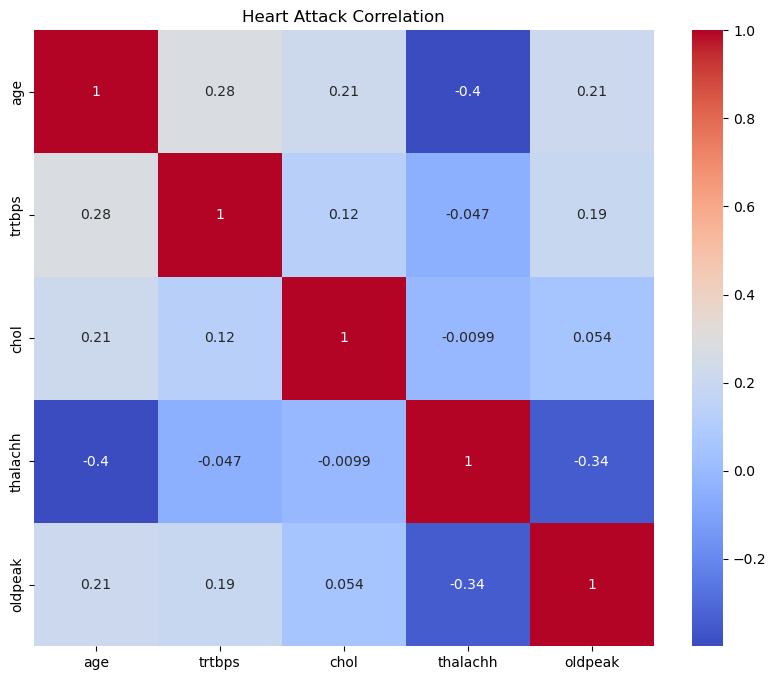

In [11]:
# correlation matrix - remove category datatype
corr_matrix = clean_df.drop(object_columns, axis = 1).corr()

# heat map plot
plt.figure(figsize=(10,8))
plt.title("Heart Attack Correlation")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

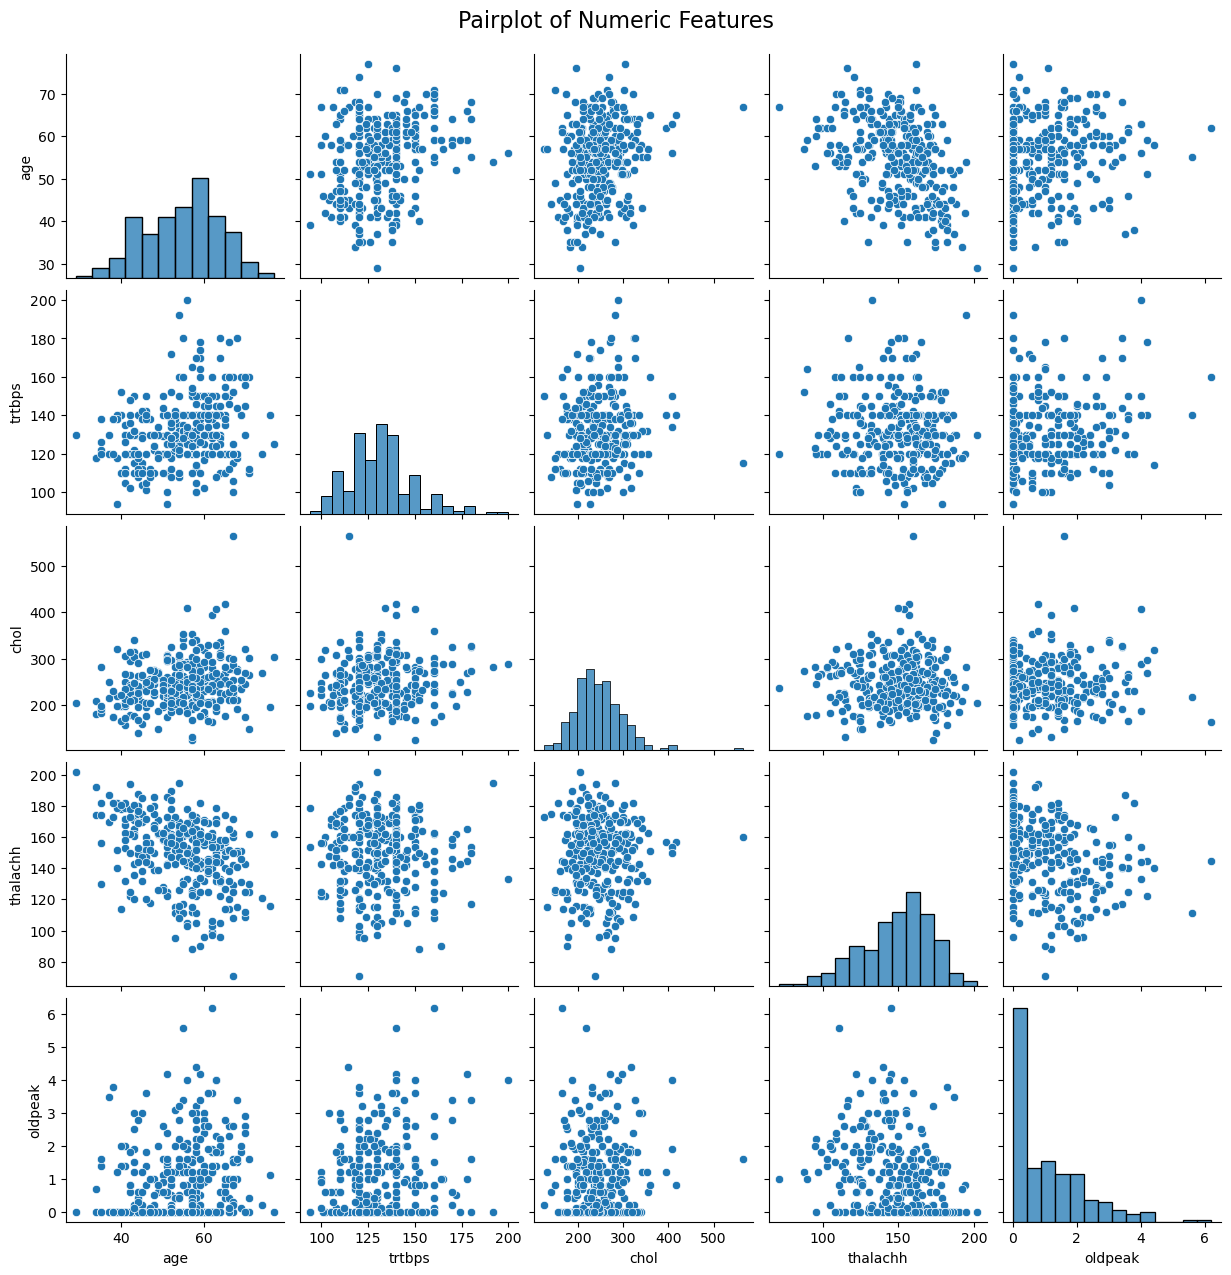

In [12]:
# pair plot 
sns.pairplot(clean_df.drop(object_columns, axis=1))
# add a heading using Matplotlib
plt.suptitle('Pairplot of Numeric Features', fontsize=16,  y=1.02)
plt.show()

**To explore the data, we first look at the descriptive statistics, correlations, and a `pairplot` of our data. Also, regarding the distribution of each variable, there are a few variables at different scales like `age`, `trtbps`, `chol`, and `thalachh`. Most distributions are normally distributed except for `oldpeak`, which is right-skewed.**

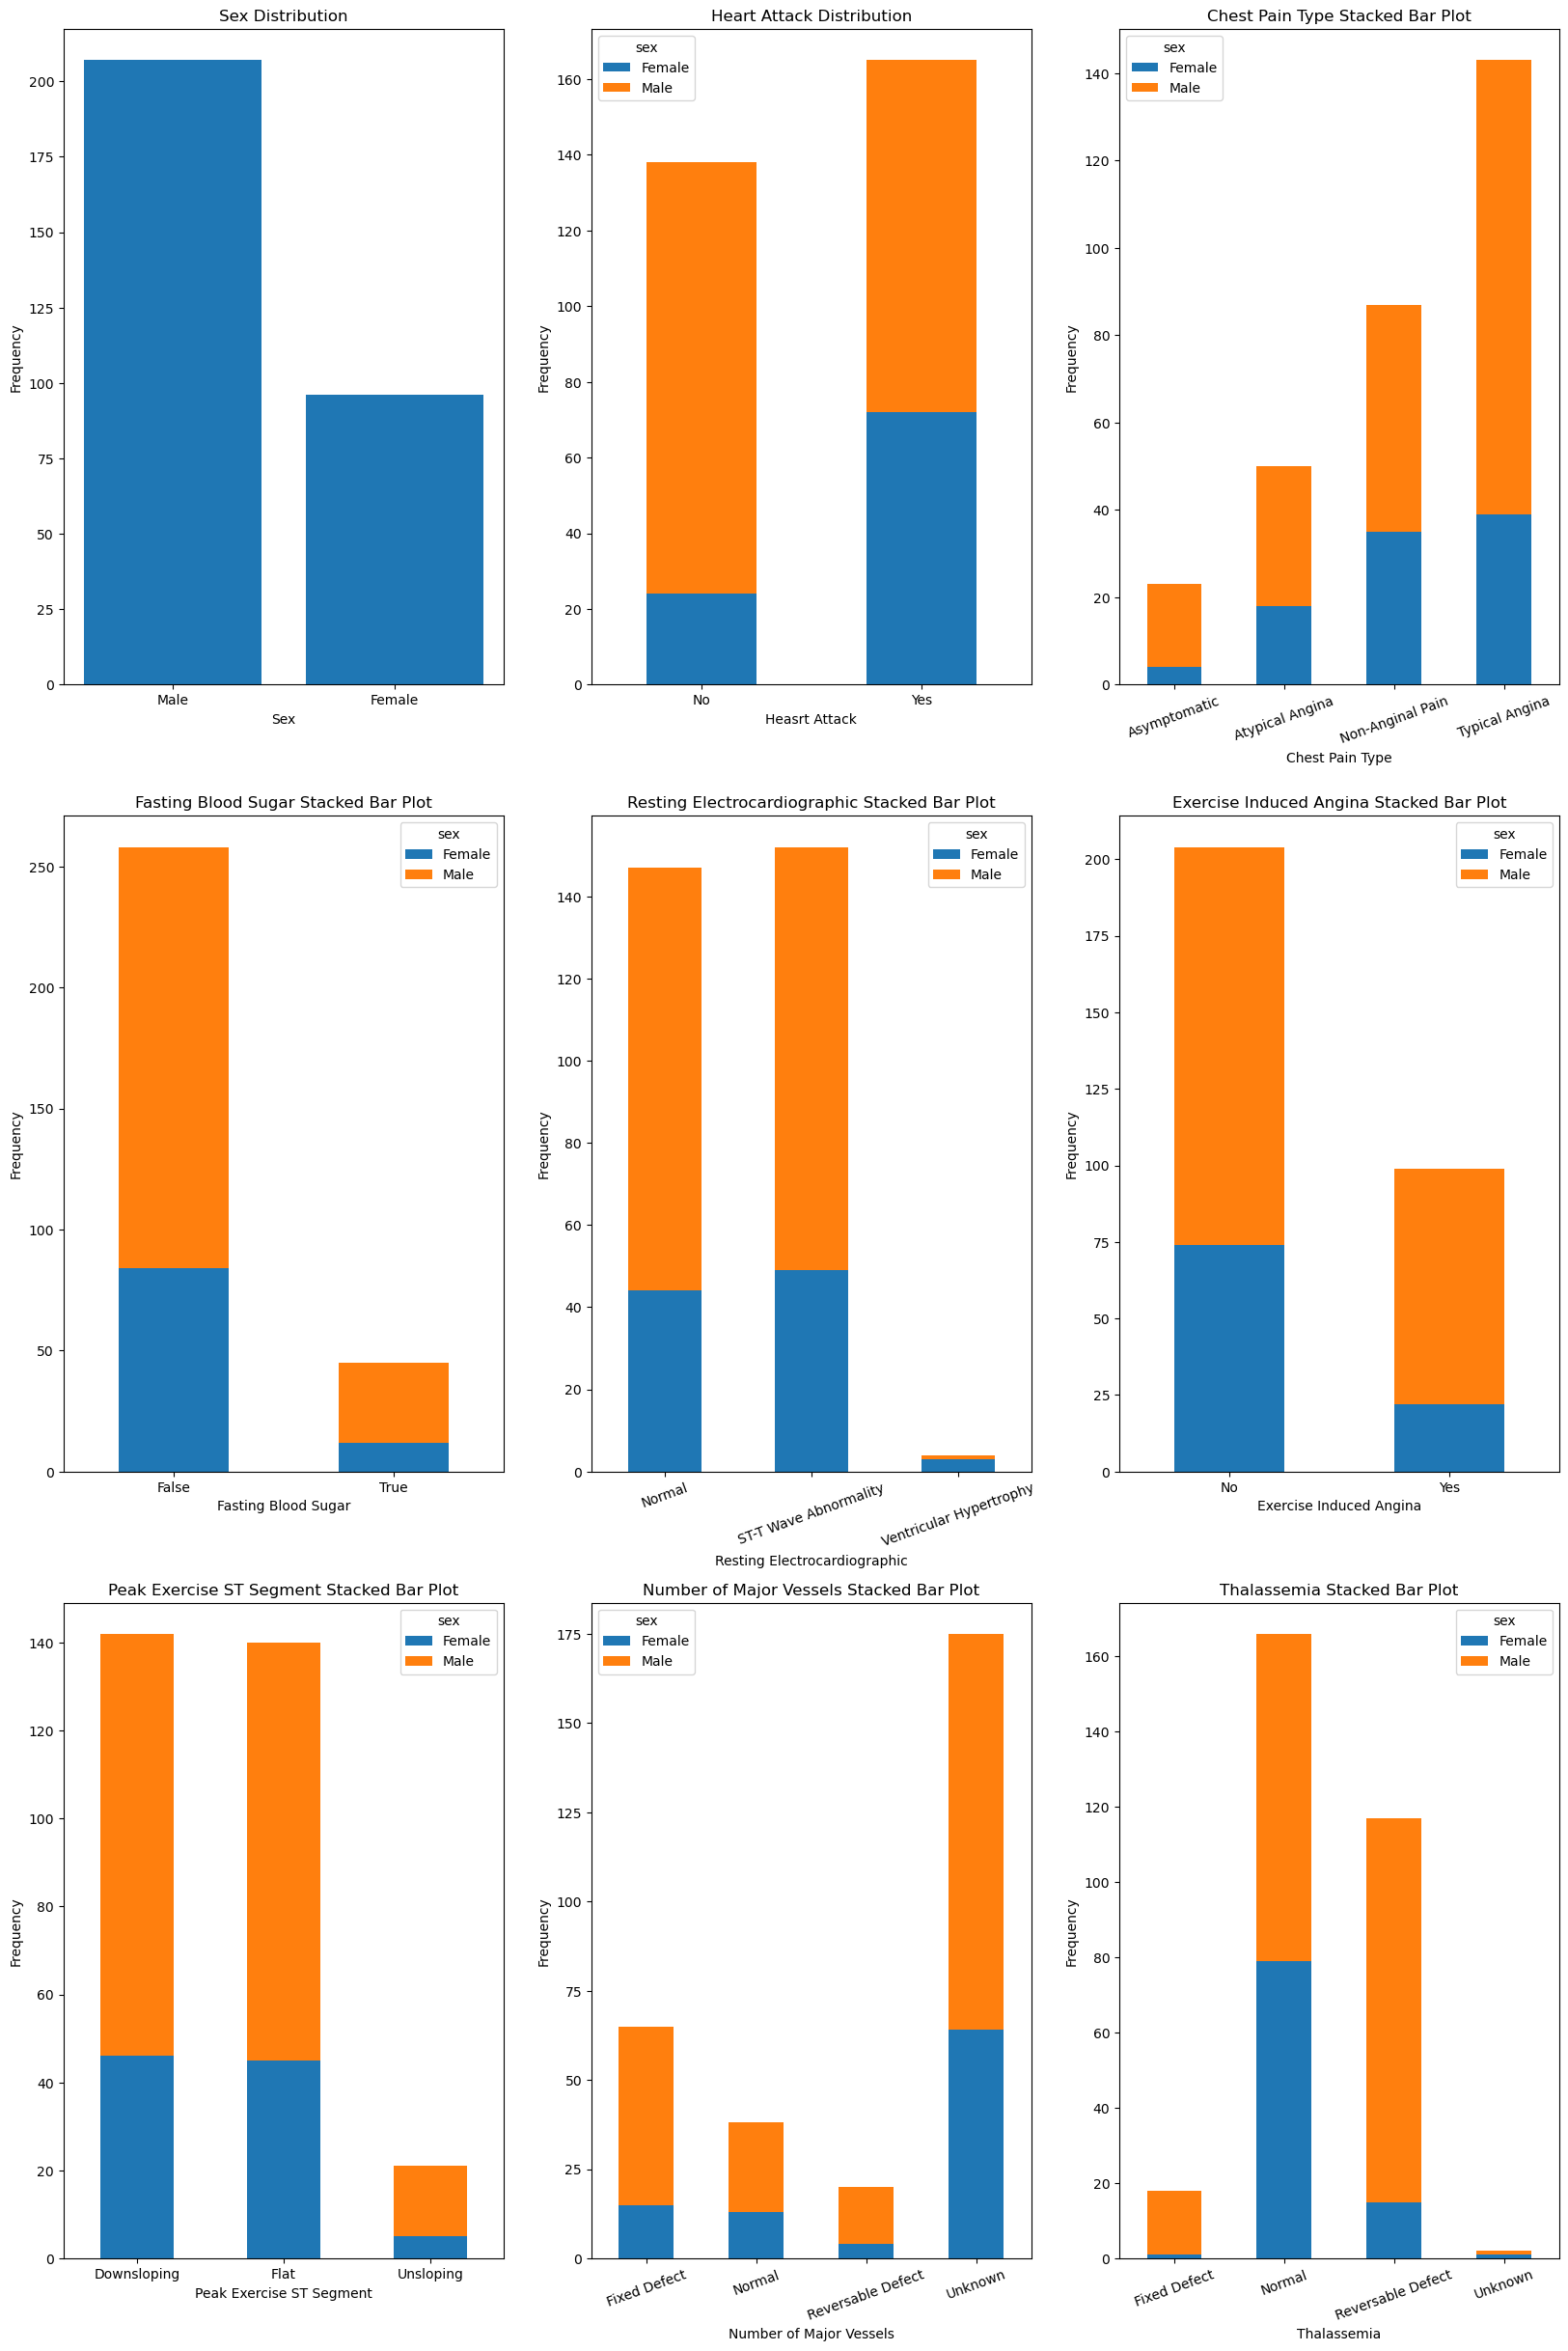

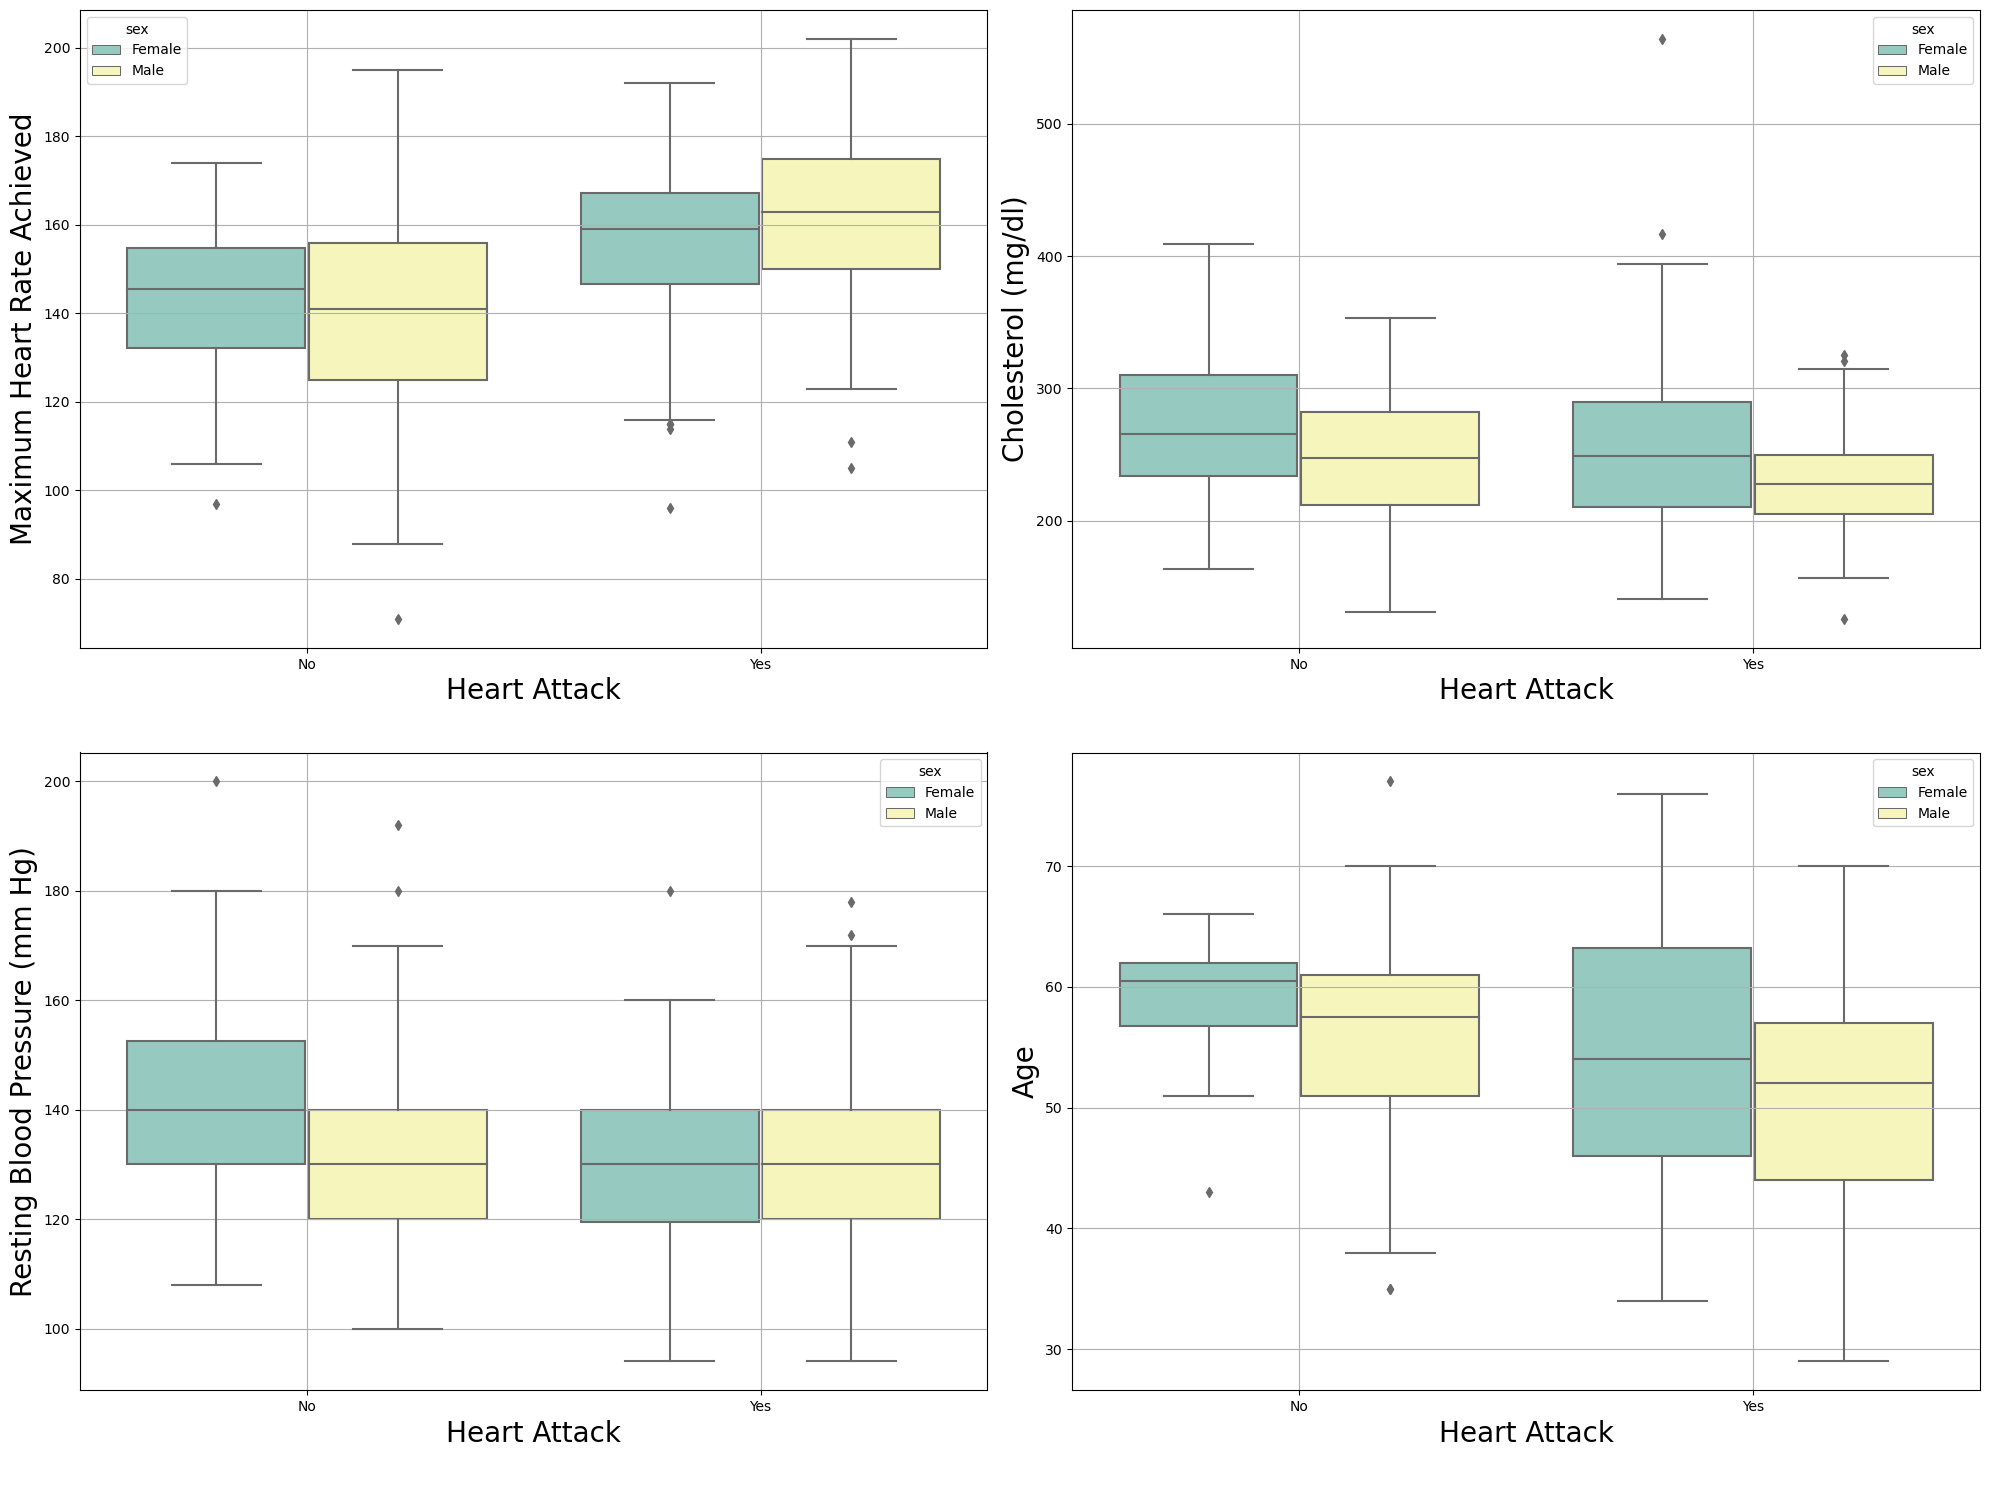

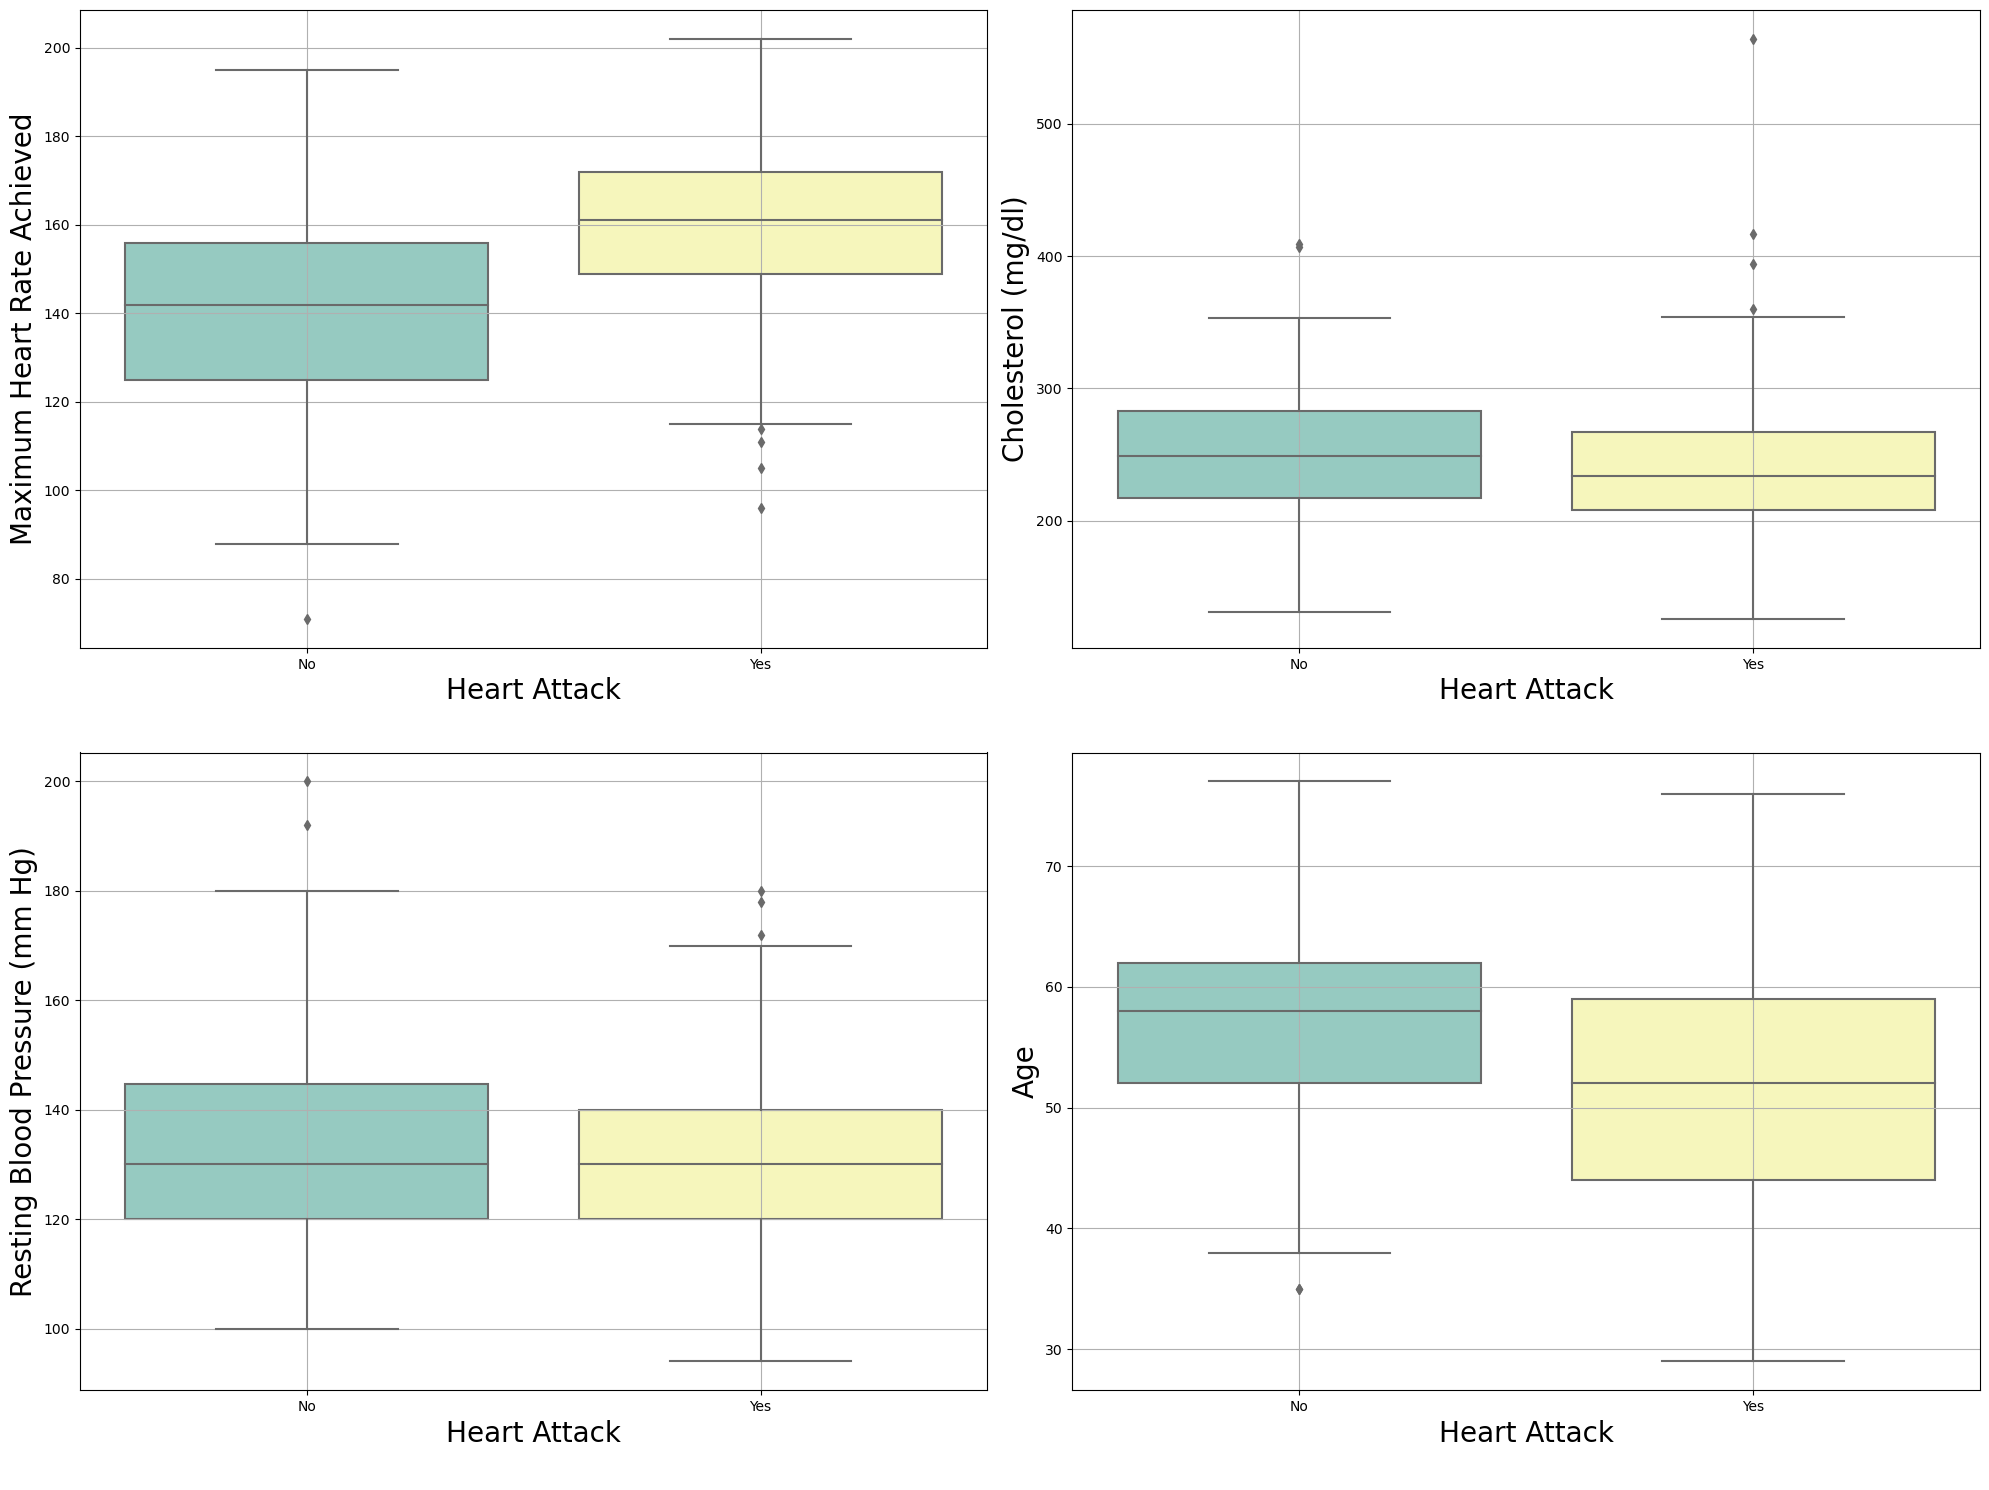

In [13]:
# set subplots for stack bar plots
fig, axs = plt.subplots(3, 3, figsize=(20,30))

# flatten axs
axs = axs.flatten()

# bar plot
axs[0].bar(clean_df.sex.unique(), clean_df.sex.value_counts())

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='output', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot = 0, ax=axs[1])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='cp', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=20, ax=axs[2])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='fbs', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=0, ax=axs[3])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='restecg', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=20, ax=axs[4])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='exng', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=0, ax=axs[5])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='slp', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=0, ax=axs[6])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='caa', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=20, ax=axs[7])

# pivoted_df DataFrame
pivoted_df = clean_df.pivot_table(index='thall', columns='sex', values='age', aggfunc='count')
pivoted_df.plot(kind='bar', stacked=True, rot=20, ax=axs[8])

# add a title and axis label for the first subplot
axs[0].set_title("Sex Distribution")
axs[0].set_xlabel("Sex")
axs[0].set_ylabel("Frequency")

# add a title and axis label for the first subplot
axs[1].set_title("Heart Attack Distribution")
axs[1].set_xlabel("Heasrt Attack")
axs[1].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[2].set_title("Chest Pain Type Stacked Bar Plot")
axs[2].set_xlabel("Chest Pain Type")
axs[2].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[3].set_title("Fasting Blood Sugar Stacked Bar Plot")
axs[3].set_xlabel("Fasting Blood Sugar")
axs[3].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[4].set_title("Resting Electrocardiographic Stacked Bar Plot")
axs[4].set_xlabel("Resting Electrocardiographic")
axs[4].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[5].set_title("Exercise Induced Angina Stacked Bar Plot")
axs[5].set_xlabel("Exercise Induced Angina")
axs[5].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[6].set_title("Peak Exercise ST Segment Stacked Bar Plot")
axs[6].set_xlabel("Peak Exercise ST Segment")
axs[6].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[7].set_title("Number of Major Vessels Stacked Bar Plot")
axs[7].set_xlabel("Number of Major Vessels")
axs[7].set_ylabel("Frequency")

# add a title and axis label for the second subplot
axs[8].set_title("Thalassemia Stacked Bar Plot")
axs[8].set_xlabel("Thalassemia")
axs[8].set_ylabel("Frequency")

plt.show()  # Display the plot

# boxplots
box_plot_features(clean_df, True)
# box plot 
box_plot_features(clean_df)

**To visualize the data, we convert a few of the binary and continuous variables to meaningful values. In the visualizations above, we see the male ratio is higher in almost all variable comparisons and gives us a visualization that Heart attack chances are more elevated in Males. This is likely due to the proportion of males/females in the data set. From the bar plot of `output`, the data is somewhat evenly balanced, so we will not perform any over/under-sampling techniques. The box plot of `Output` vs. `Age` shows heart attack is more frequent in the ages 44 ~ 58, which does tell a story about people with bad habits that can eventually lead to heart attacks in that age range.**

**An interesting question is whether some of the factors, like chest pain and high blood sugar, lead to heart attacks and why these levels are all high in males.**

### Examing Age and the Effects of Heart Attack

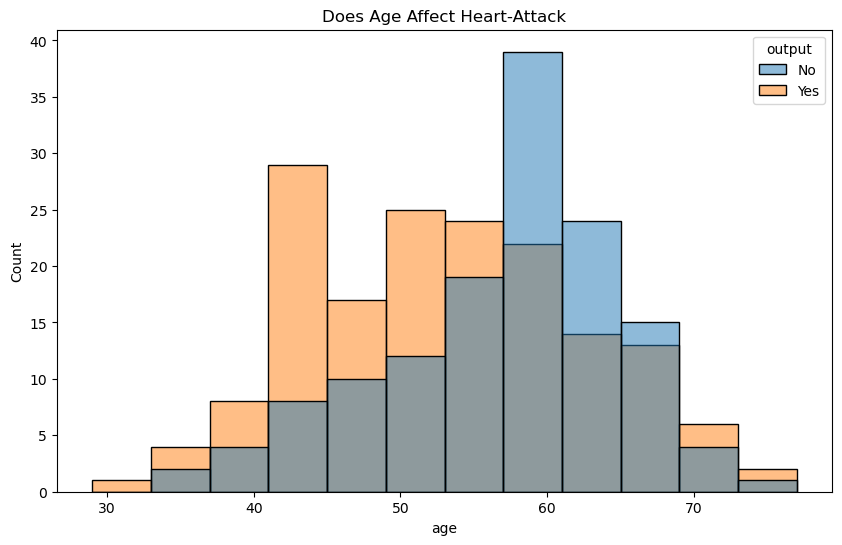

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(data = clean_df, x = 'age', hue = 'output')
plt.title("Does Age Affect Heart-Attack")
plt.show()

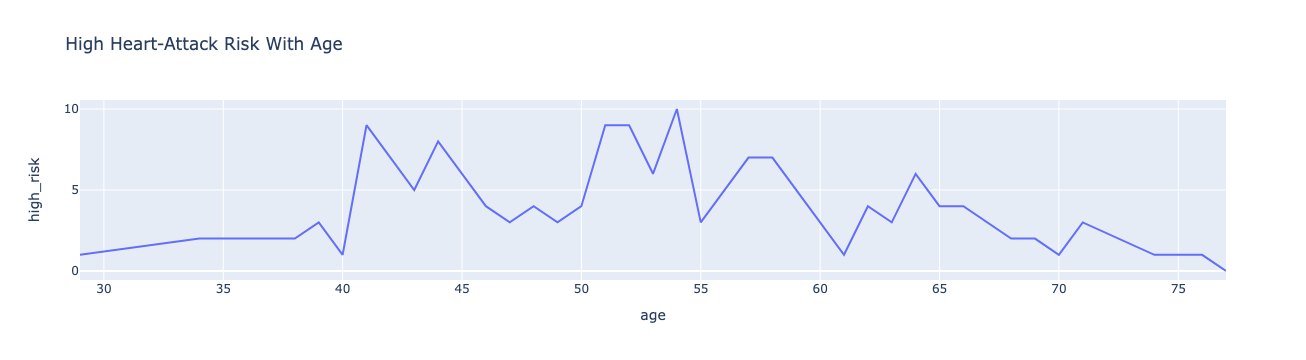

In [15]:
# cross table table
v = pd.crosstab(clean_df["age"],df["output"]).reset_index()

# column name
v.columns=["age","low_risk","high_risk"]

# plot heart-attack risk
px.line(v,v["age"],v["high_risk"],title="High Heart-Attack Risk With Age")

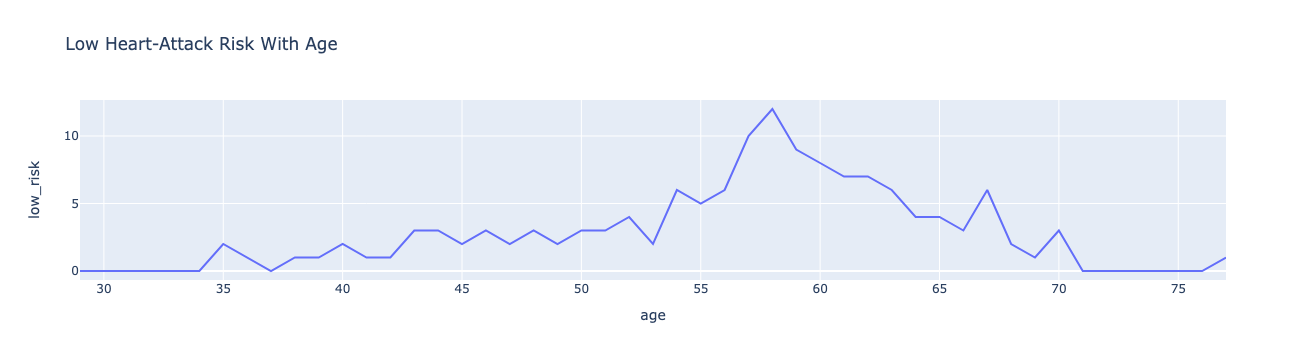

In [16]:
# plot heart-attack risk
px.line(v,v["age"],v["low_risk"],title="Low Heart-Attack Risk With Age")

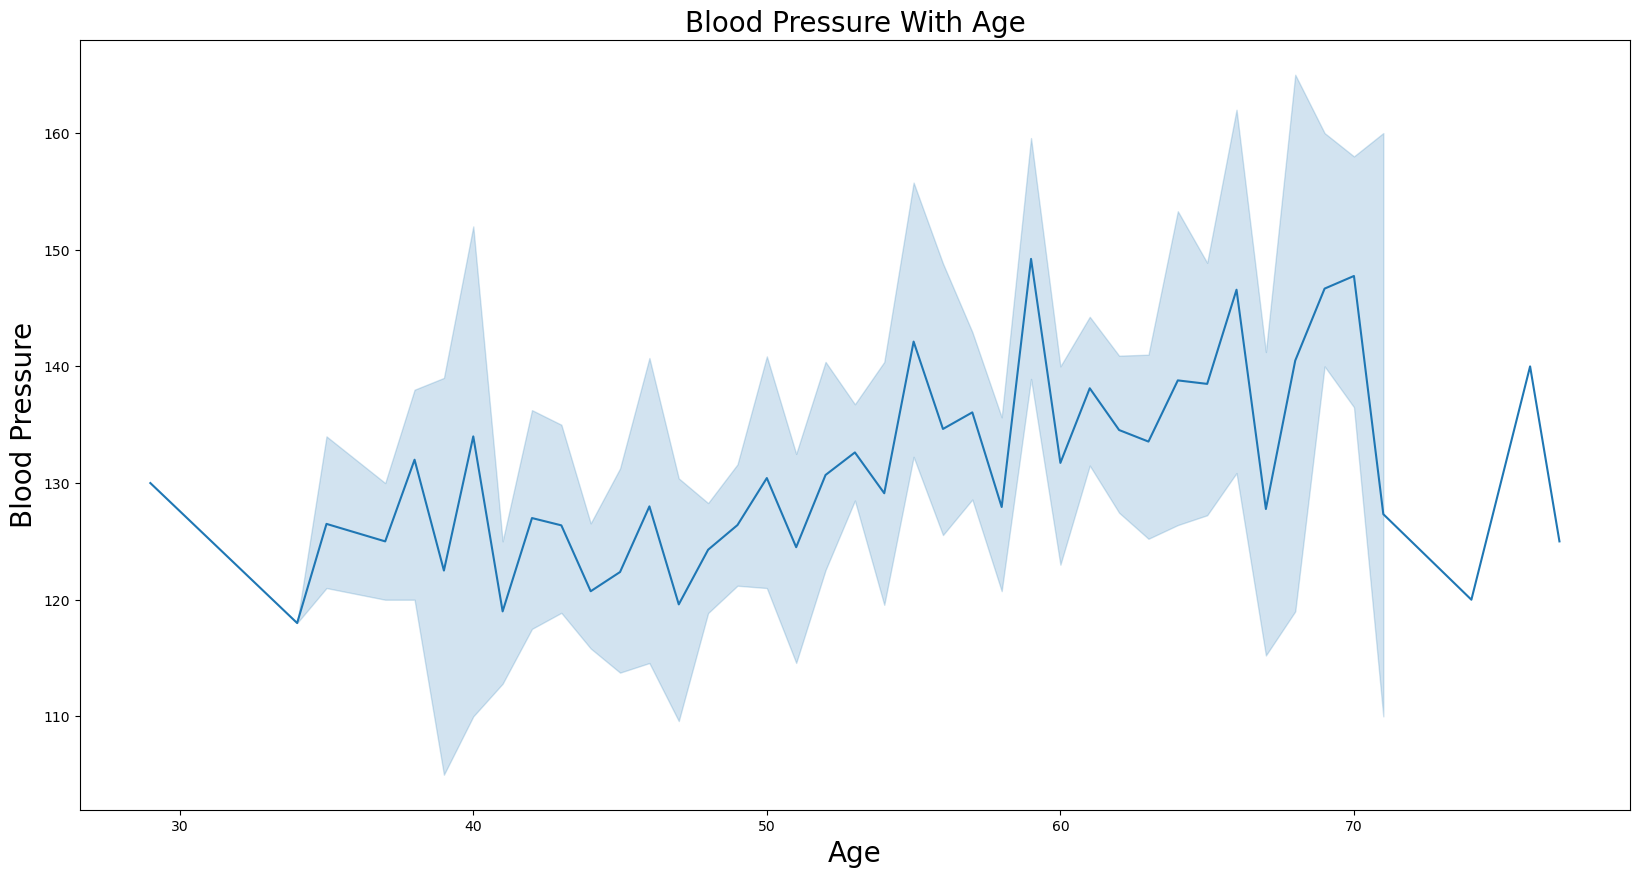

In [17]:
plt.figure(figsize=(20,10))
sns.lineplot(y="trtbps",x="age",data=clean_df)
plt.title("Blood Pressure With Age",fontsize=20)
plt.xlabel("Age",fontsize=20)
plt.ylabel("Blood Pressure",fontsize=20)
plt.show()

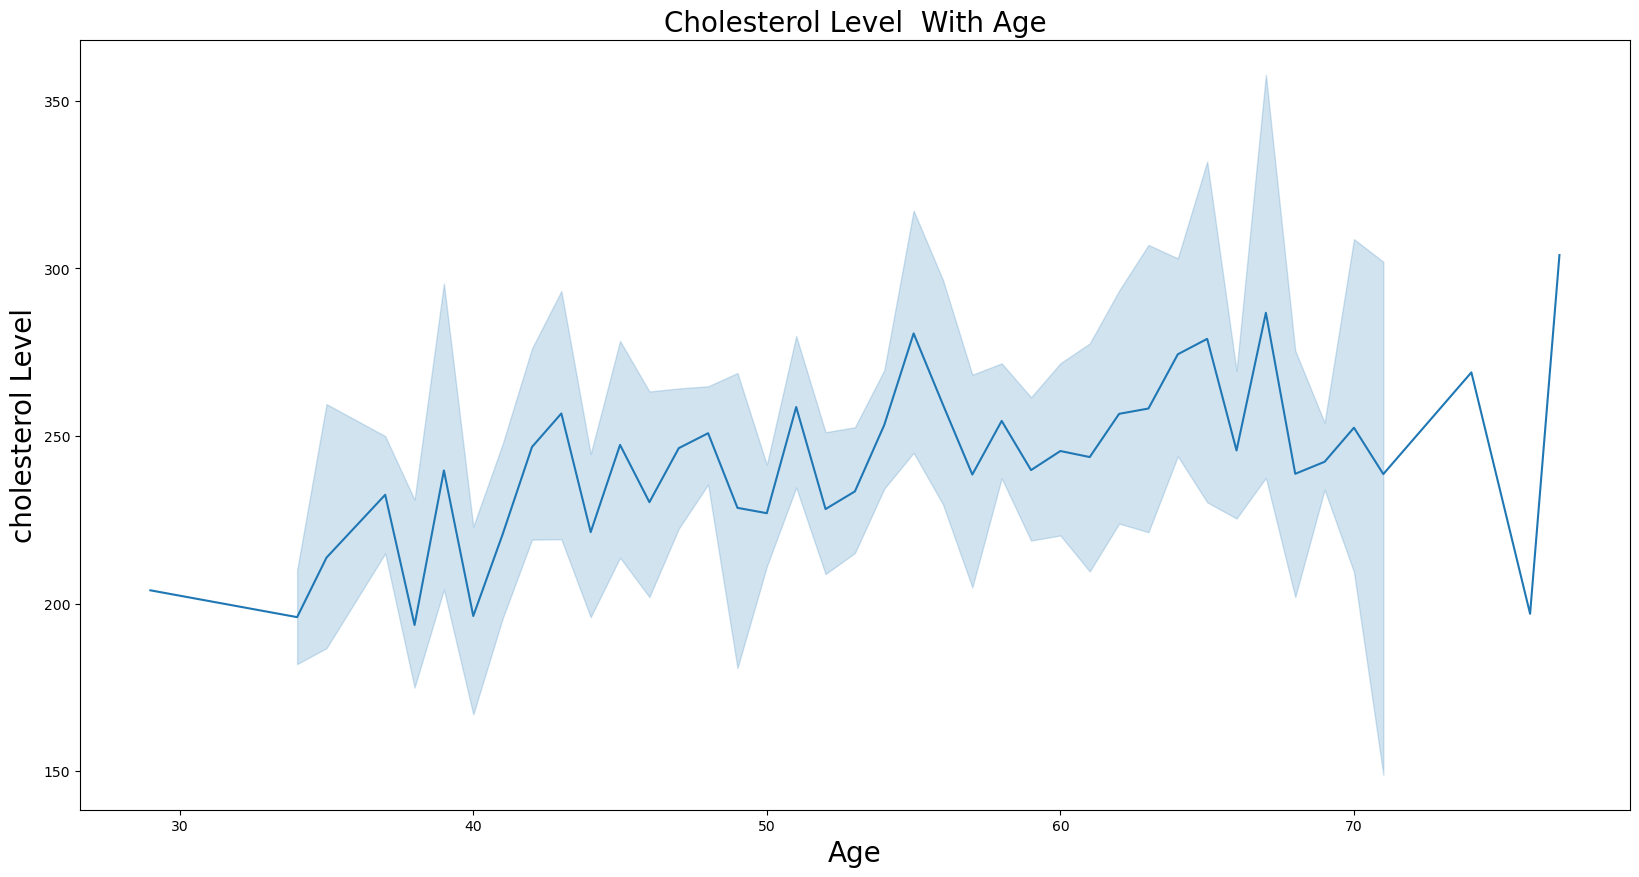

In [18]:
plt.figure(figsize=(20,10))
sns.lineplot(y="chol",x="age",data=clean_df)
plt.title("Cholesterol Level  With Age",fontsize=20)
plt.xlabel("Age",fontsize=20)
plt.ylabel("cholesterol Level",fontsize=20)
plt.show()

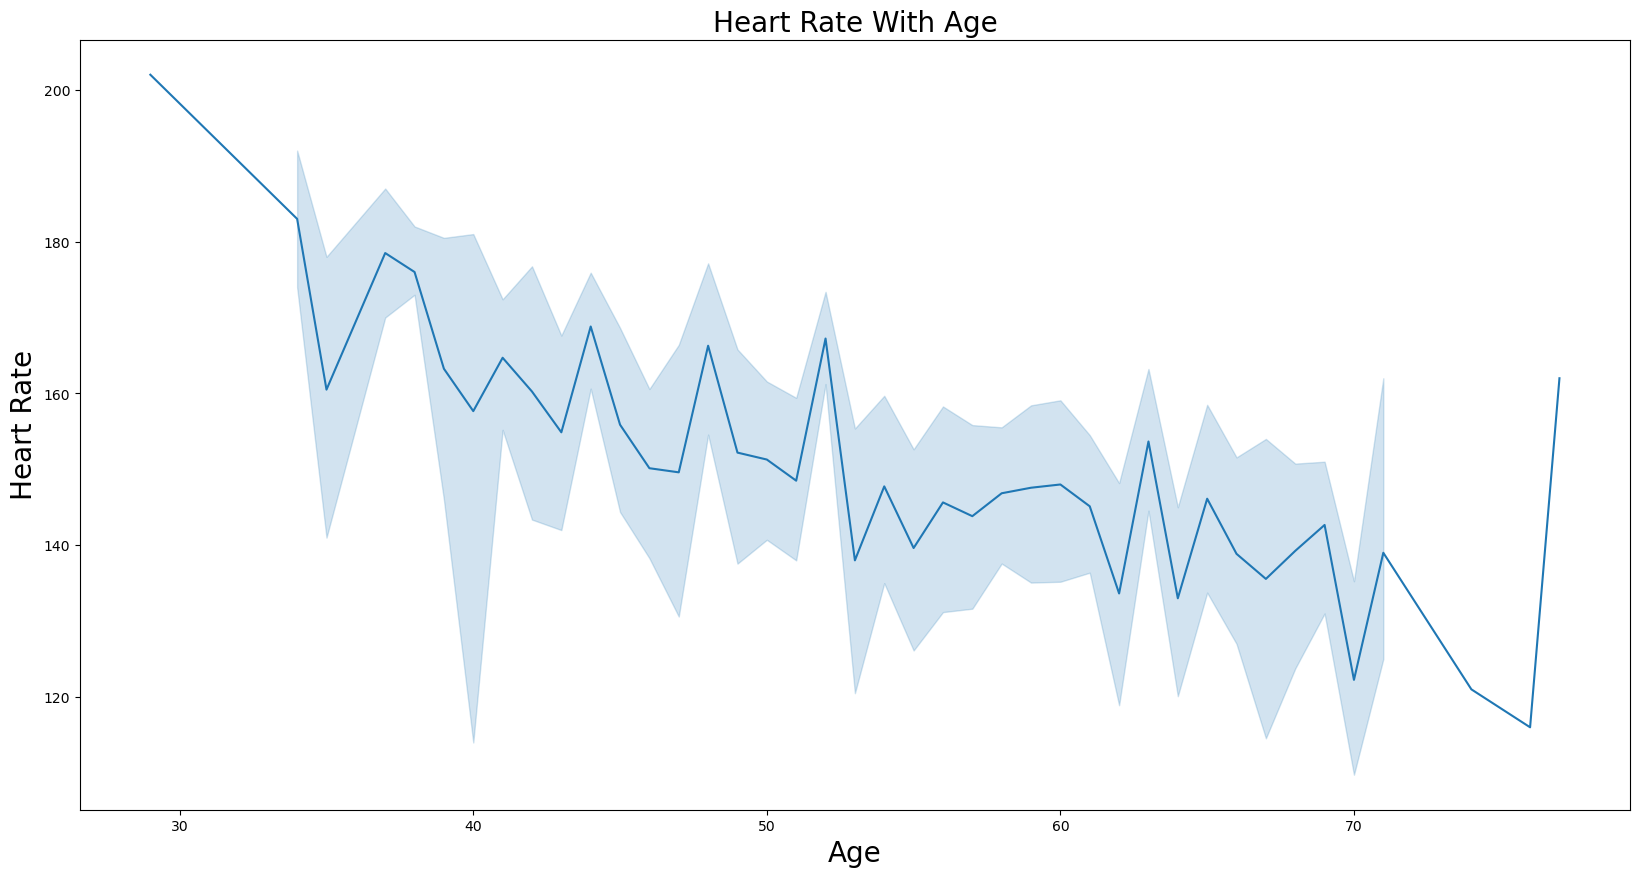

In [19]:
plt.figure(figsize=(20,10))
sns.lineplot(y="thalachh",x="age",data=clean_df)
plt.title("Heart Rate With Age",fontsize=20)
plt.xlabel("Age",fontsize=20)
plt.ylabel("Heart Rate",fontsize=20)
plt.show()

#### Insight: Bivariate Analysis of the Data
 - **Age and Likelihood of Heart Attack:** 
    - There isn't a significant correlation between age and the likelihood of a heart attack. This lack of a direct relationship makes it challenging to assert that an increase in age corresponds to a higher or lower probability of a heart attack.
- **Blood Pressure and Age:**
    - There is a notable tendency for blood pressure to rise with age. As individuals get older, an observable trend shows an increase in blood pressure.
- **Age and Cholesterol Levels:**
    - There is a correlation between age and higher cholesterol levels. This suggests that cholesterol levels tend to increase as individuals age.
- **Age and Heart Rate:**
    - The data indicates a positive association between age and heart rate. This implies that heart rates are likely to elevate with advancing age.
    
These observations suggest that while age might not directly correlate with the likelihood of a heart attack, it does show correlations with other cardiovascular factors such as blood pressure, cholesterol levels, and heart rate. These associations between age and these cardiovascular indicators highlight the importance of monitoring these factors as individuals grow older, as they might contribute to potential cardiovascular health risks.

### Multi-Variate Analysis:

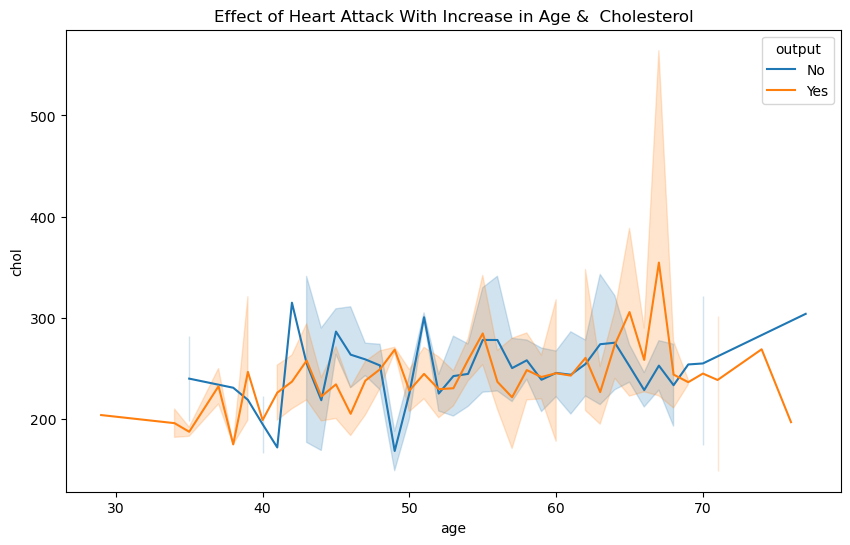

In [20]:
plt.figure(figsize=(10,6))
sns.lineplot(x="age",y="chol",hue="output",data=clean_df)
plt.title("Effect of Heart Attack With Increase in Age &  Cholesterol")
plt.show()

**Q1: Does an increase in blood pressure in a body have any effect on the heart attack:**

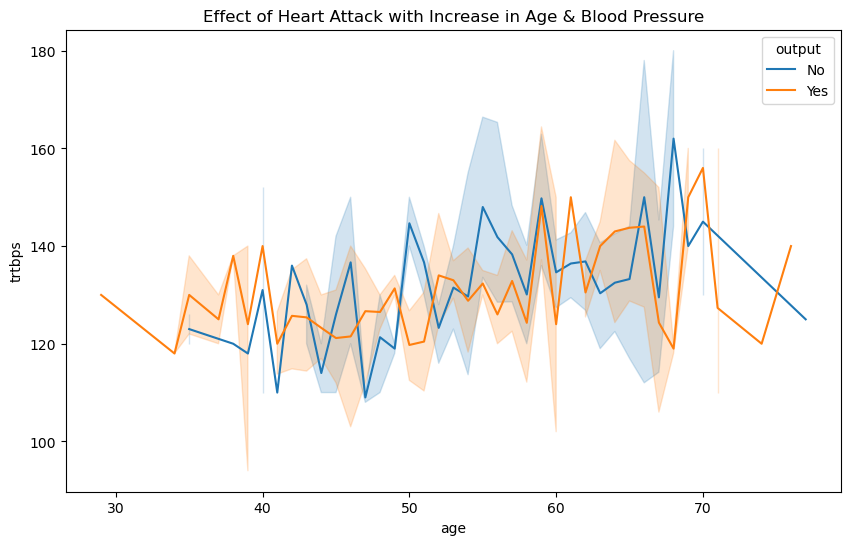

In [21]:
plt.figure(figsize=(10,6))
sns.lineplot(x="age",y="trtbps",hue="output",data=clean_df)
plt.title("Effect of Heart Attack with Increase in Age & Blood Pressure")
plt.show()

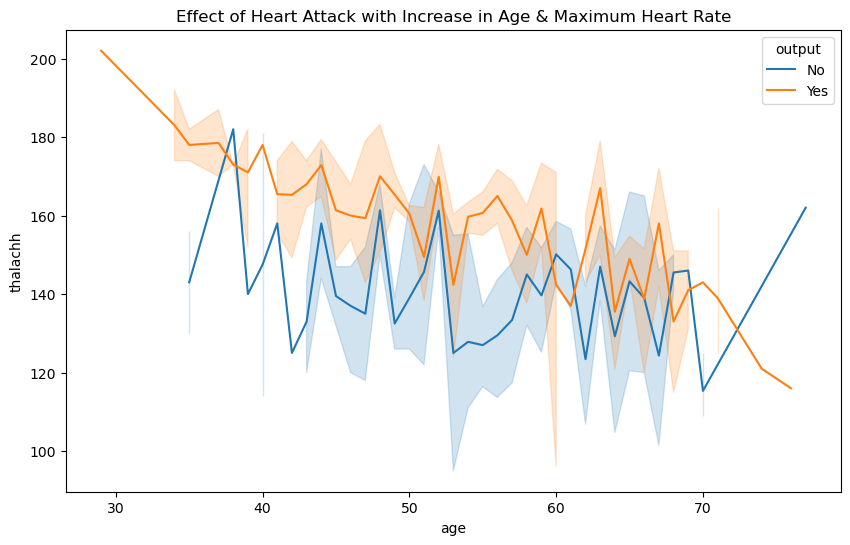

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(x="age",y="thalachh",hue="output",data=clean_df)
plt.title("Effect of Heart Attack with Increase in Age & Maximum Heart Rate")
plt.show()

### The insights from the multivariate analysis of the data can be summarized as follows:

- **Age and Cholesterol Level:**
    - There is an observed trend that cholesterol levels tend to rise as age increases. However, despite this increase in cholesterol levels with age, there isn't a solid or significant relationship indicating that higher cholesterol levels directly lead to a higher risk of a heart attack. This suggests that while age might influence cholesterol levels, the relationship between cholesterol and the risk of a heart attack may not be straightforward or solely dependent on age-related increases in cholesterol.

- **Blood Pressure and Heart Attack Risk:**
    - An increase in blood pressure appears to be associated with a higher risk of a heart attack. This observation suggests that individuals with elevated blood pressure might have an increased risk of experiencing a heart attack.

- **Heart Rate and Heart Attack Risk:**
    - There is a correlation indicating that individuals with higher heart rates have a higher risk of a heart attack. Elevated heart rates could be a potential indicator of an increased risk of experiencing a heart attack.

In summary, while age might influence cholesterol levels, the direct impact of increased cholesterol on the likelihood of a heart attack might not be conclusive. However, higher blood pressure and elevated heart rates appear to be more directly associated with an increased risk of experiencing a heart attack based on the analysis of the data. These insights highlight the importance of monitoring blood pressure and heart rate as potential indicators of the risk of a heart attack.

#### Prepare data for machine learning

In [24]:
RANDOM_STATE = 1776

# create dummy variables for the categorical features
dummies_df = pd.get_dummies(clean_df, columns=object_columns[:-1], drop_first = True)

In [25]:
# initialize X & y variable
X = dummies_df.drop('output', axis = 1)
y = np.where(dummies_df['output'] == 'Yes', 1,0).astype(np.intc)

# split train & test using stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)

In [26]:
# instantiate Standar Scaler
ss = StandardScaler()

# fit train
ss.fit(X_train)

# transform train & test
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

**After applying the Standard Scaler, each feature (column) will have a mean of 0 and a standard deviation of 1. This helps when you have features with different scales, as it ensures that no particular feature dominates the others while training machine learning models on algorithms utilizing distance functions.**

In [27]:
# check shape
X_train.shape, X_test.shape

((212, 21), (91, 21))

# Machine Learning Models

### Logistic Regression

In [28]:
# define the hyperparameter grid to search
parameters = dict(
C = np.linspace(0.15, 2, 15),
max_iter = [75, 100, 125, 175, 200, 250]
)
# Base Model
lr_param = {'random_state': RANDOM_STATE}

# instantiate Logistic Regression
model = LogisticRegression(**lr_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train, y_train)

CV accuracy: 0.886 +/- 0.087


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9130434782608695
Specificity:            0.8247422680412371
Precision:              0.860655737704918
Balanced Accuracy:      0.8688928731510532
F1 Score:               0.8860759493670886




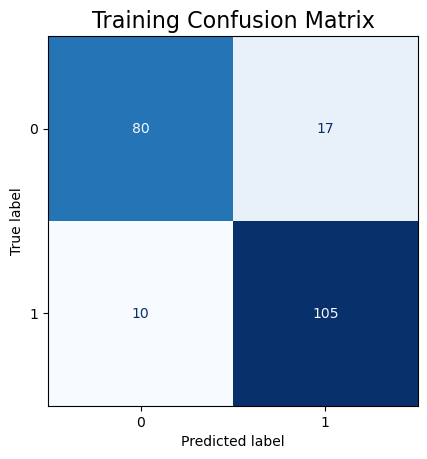



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7317073170731707
Precision:              0.8103448275862069
Balanced Accuracy:      0.8358536585365853
F1 Score:               0.8703703703703703




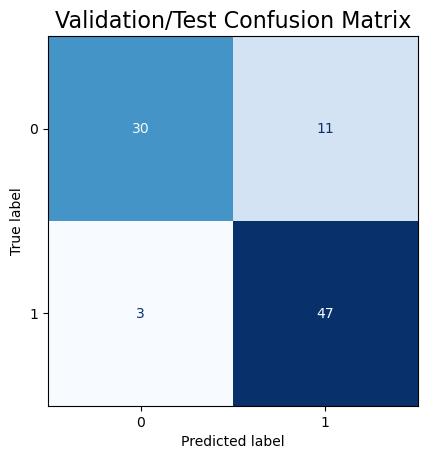

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                          
LogisticRegression                   0.913043           0.824742   

                    Precision Train  Balanced Accuracy Train  F1 Train  \
Algorithm                                                                
LogisticRegression         0.860656                 0.868893  0.886076   

                    Recall(Sensitivity) Validation/Test  \
Algorithm                                                 
LogisticRegression                                 0.94   

                    Specificity Validation/Test  Precision Validation/Test  \
Algorithm                                                                    
LogisticRegression                     0.731707                   0.810345   

                    Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                                  
LogisticRegression                           0.835854             0.87037

In [29]:
ML = "LogisticRegression"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:,2:]

#### SVC

In [30]:
# define the hyperparameter grid to search
parameters = dict(
C = [5, 6, 7, 8, 9],
gamma = [0.001, 0.002, 0.01]
)
# Base Model
svc_param = {'random_state': RANDOM_STATE}

# instantiate SVC
model = SVC(**svc_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train, y_train)

CV accuracy: 0.868 +/- 0.107


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8956521739130435
Specificity:            0.8144329896907216
Precision:              0.8512396694214877
Balanced Accuracy:      0.8550425818018825
F1 Score:               0.8728813559322034




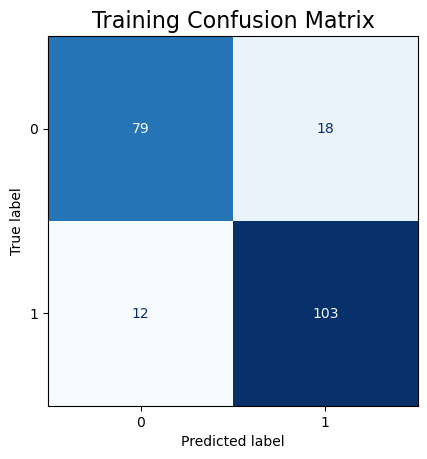



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7317073170731707
Precision:              0.8103448275862069
Balanced Accuracy:      0.8358536585365853
F1 Score:               0.8703703703703703




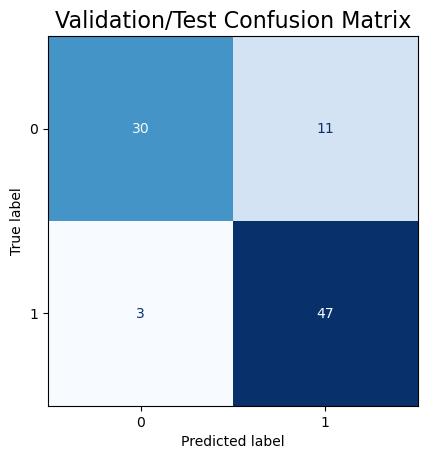

Recall(Sensitivity) Train  Specificity Train  Precision Train  \
Algorithm                                                                  
SVC                         0.895652           0.814433          0.85124   

           Balanced Accuracy Train  F1 Train  \
Algorithm                                      
SVC                       0.855043  0.872881   

           Recall(Sensitivity) Validation/Test  Specificity Validation/Test  \
Algorithm                                                                     
SVC                                       0.94                     0.731707   

           Precision Validation/Test  Balanced Accuracy Validation/Test  \
Algorithm                                                                 
SVC                         0.810345                           0.835854   

           F1 Validation/Test  
Algorithm                      
SVC                   0.87037

In [31]:
ML = "SVC"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

#### Random Forest Classifier

In [32]:
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 6, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(5,11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

In [33]:
# define the hyperparameter grid to search
parameters = dict(
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train, y_train)

CV accuracy: 0.887 +/- 0.065


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9217391304347826
Specificity:            0.8041237113402062
Precision:              0.848
Balanced Accuracy:      0.8629314208874944
F1 Score:               0.8833333333333334




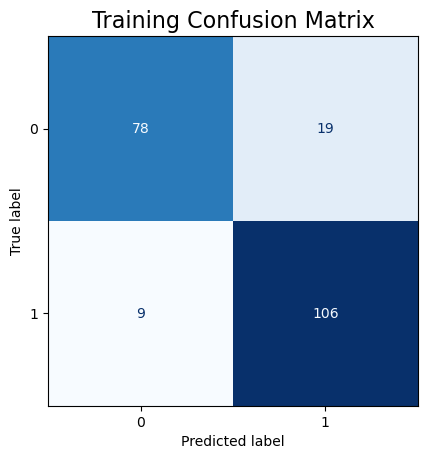



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.96
Specificity:            0.7317073170731707
Precision:              0.8135593220338984
Balanced Accuracy:      0.8458536585365853
F1 Score:               0.8807339449541285




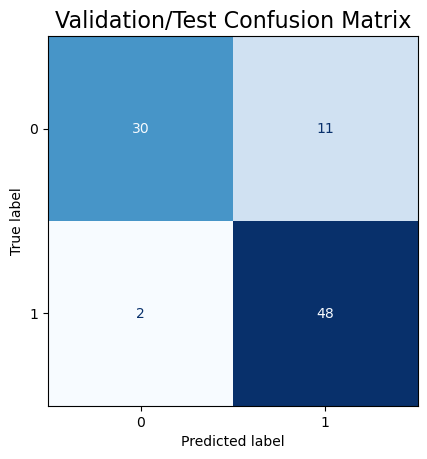



                                 % Feature Importance
caa_Unknown                                 22.010918
cp_Typical Angina                           15.365130
thall_Normal                                12.582431
thall_Reversable Defect                     12.186709
exng_Yes                                    11.706005
slp_Flat                                     8.183226
thalachh                                     6.390711
oldpeak                                      5.484622
sex_Male                                     2.041763
age                                          1.250629
chol                                         1.190918
caa_Normal                                   0.554973
cp_Non-Anginal Pain                          0.543151
cp_Atypical Angina                           0.508814
caa_Reversable Defect                        0.000000
restecg_ST-T Wave Abnormality                0.000000
slp_Unsloping                                0.000000
restecg_Ventricular Hypert

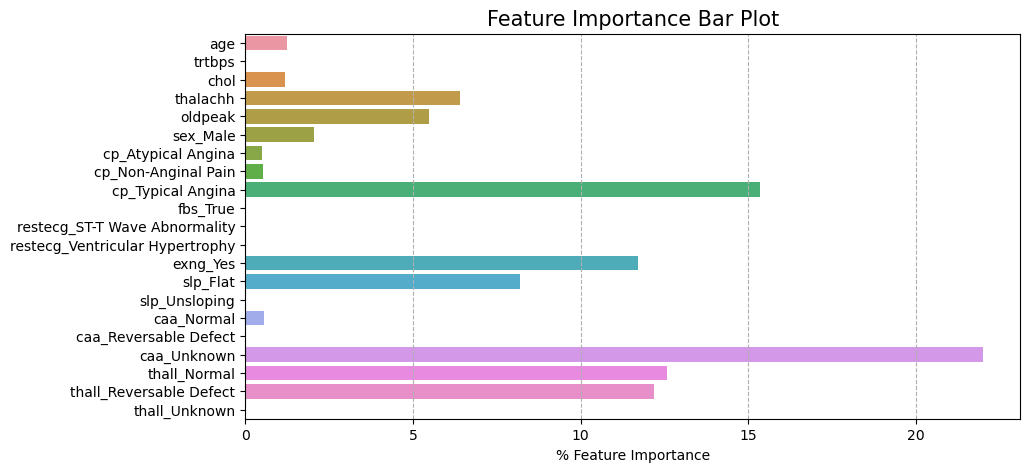

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                              
RandomForestClassifier                   0.921739           0.804124   

                        Precision Train  Balanced Accuracy Train  F1 Train  \
Algorithm                                                                    
RandomForestClassifier            0.848                 0.862931  0.883333   

                        Recall(Sensitivity) Validation/Test  \
Algorithm                                                     
RandomForestClassifier                                 0.96   

                        Specificity Validation/Test  \
Algorithm                                             
RandomForestClassifier                     0.731707   

                        Precision Validation/Test  \
Algorithm                                           
RandomForestClassifier                   0.813559   

                        Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                                      
RandomForestClassifier                           0.845854            0.880734

In [34]:
ML = "RandomForestClassifier"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
plot_feature_importance(model, clean_df)

df_.iloc[:, 2:]

#### XGB Classifier

In [35]:
# define the hyperparameter grid to search
parameters = {
    "learning_rate": [0.01, 0.02, 0.03],  # learning rate
    "max_depth": [2, 3, 4], # control over-fitting as higher depth will allow the model to learn relations very specific
    "gamma": [0, 0.6, 1], # the minimum loss reduction required to make a split
    'subsample': [0.7, 0.8], # fraction of data used for each tree
    'min_child_weight': [2, 3, 4],
}

# define default XGB Classifier parameters 
xgb_param = {
    'disable_default_eval_metric':  'true',
    'tree_method':                  'hist', # constructs trees using a histogram-based & memory-efficient and fast
    'random_state': RANDOM_STATE,
}

# instantiate XGB Classifier
model = xgb.XGBClassifier(**xgb_param)

# CV_GS
fit = stratified_grid(model, parameters, X_train, y_train)

CV accuracy: 0.877 +/- 0.079


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9217391304347826
Specificity:            0.8247422680412371
Precision:              0.8617886178861789
Balanced Accuracy:      0.8732406992380098
F1 Score:               0.8907563025210083




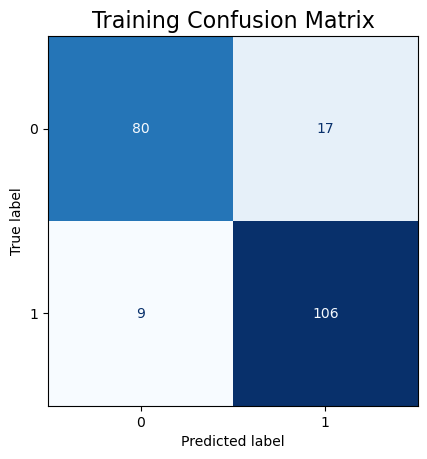



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.96
Specificity:            0.7317073170731707
Precision:              0.8135593220338984
Balanced Accuracy:      0.8458536585365853
F1 Score:               0.8807339449541285




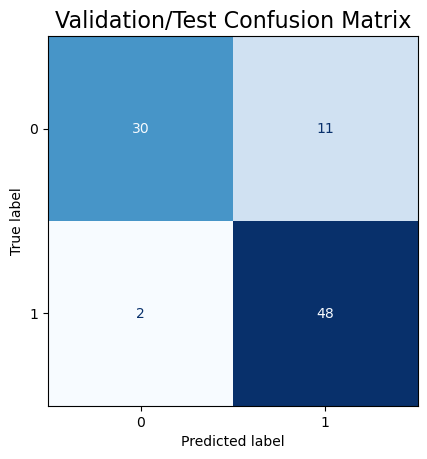



                                 % Feature Importance
thall_Normal                                19.598125
exng_Yes                                    14.924629
thall_Reversable Defect                      9.491032
caa_Unknown                                  8.974626
cp_Typical Angina                            8.353235
slp_Flat                                     6.822786
oldpeak                                      6.033272
thalachh                                     4.882134
restecg_ST-T Wave Abnormality                3.363970
cp_Non-Anginal Pain                          3.337728
chol                                         3.236966
sex_Male                                     2.736604
caa_Normal                                   2.430062
age                                          2.410326
trtbps                                       2.194890
slp_Unsloping                                1.209606
restecg_Ventricular Hypertrophy              0.000000
caa_Reversable Defect     

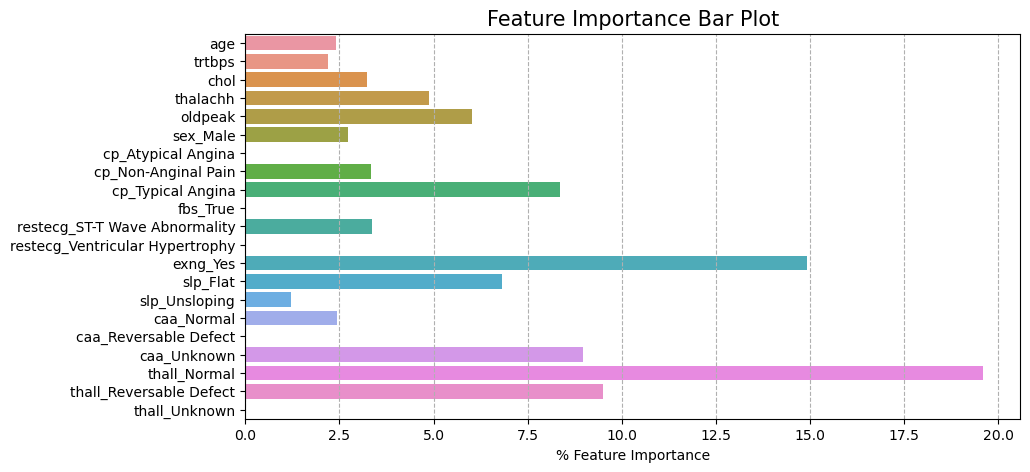

Recall(Sensitivity) Train  Specificity Train  Precision Train  \
Algorithm                                                                      
XGBClassifier                   0.921739           0.824742         0.861789   

               Balanced Accuracy Train  F1 Train  \
Algorithm                                          
XGBClassifier                 0.873241  0.890756   

               Recall(Sensitivity) Validation/Test  \
Algorithm                                            
XGBClassifier                                 0.96   

               Specificity Validation/Test  Precision Validation/Test  \
Algorithm                                                               
XGBClassifier                     0.731707                   0.813559   

               Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                             
XGBClassifier                           0.845854            0.880734

In [36]:
ML = "XGBClassifier"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
plot_feature_importance(model, clean_df)

# display
df_.iloc[:, 2:]

#### Linear Discriminant Analysis

In [37]:
# define the hyperparameter grid to search
parameters = {
    'solver': ['svd', 'lsqr', 'eigen']
}

# define default Linear Discriminant Analysis Classifier parameters 
lda_param = {
    'n_components': None,
}

# instantiate XGB Classifier
model = LinearDiscriminantAnalysis(**lda_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train, y_train)

CV accuracy: 0.887 +/- 0.065


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9304347826086956
Specificity:            0.8144329896907216
Precision:              0.856
Balanced Accuracy:      0.8724338861497086
F1 Score:               0.8916666666666667




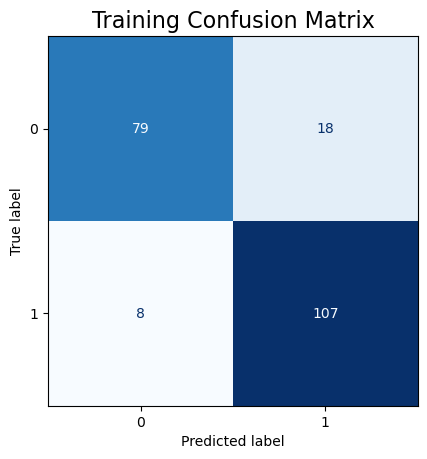



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7073170731707317
Precision:              0.7966101694915254
Balanced Accuracy:      0.8236585365853658
F1 Score:               0.8623853211009174




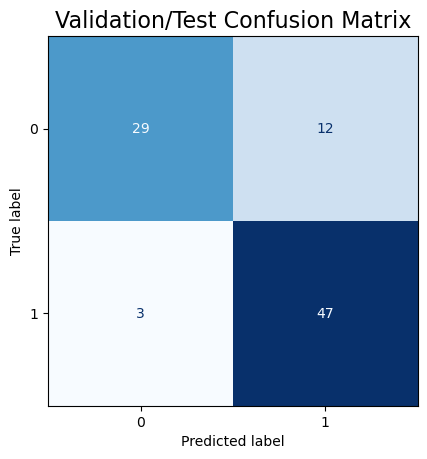

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                                  
LinearDiscriminantAnalysis                   0.930435           0.814433   

                            Precision Train  Balanced Accuracy Train  \
Algorithm                                                              
LinearDiscriminantAnalysis            0.856                 0.872434   

                            F1 Train  Recall(Sensitivity) Validation/Test  \
Algorithm                                                                   
LinearDiscriminantAnalysis  0.891667                                 0.94   

                            Specificity Validation/Test  \
Algorithm                                                 
LinearDiscriminantAnalysis                     0.707317   

                            Precision Validation/Test  \
Algorithm                                               
LinearDiscriminantAnalysis                    0.79661   

                            Balanced Accuracy Validation/Test  \
Algorithm                                                       
LinearDiscriminantAnalysis                           0.823659   

                            F1 Validation/Test  
Algorithm                                       
LinearDiscriminantAnalysis            0.862385

In [38]:
ML = "LinearDiscriminantAnalysis"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

**All the classifiers listed below performed very well and do not show signs of overfitting since the difference between training and testing sets on balance accuracy difference is roughly three percent on our five classifiers. Two noticeable classifiers stand out from others: `Random Forest` & `XGBoost` provided `Recall/Sensitivity`at `96%`, and `F1` at `88%`, which provides an excellent generalization of a possible heart attack of the unseen dataset but the major difference between two classifiers is that `XGBoost` is slightly superior in the training set but did not translate into the unseen dataset.**

In [39]:
classify_performance_df.iloc[:,2:].sort_values(by=['Recall(Sensitivity) Validation/Test', 'F1 Validation/Test'], ascending=False)

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                                  
XGBClassifier                                0.921739           0.824742   
RandomForestClassifier                       0.921739           0.804124   
SVC                                          0.895652           0.814433   
LogisticRegression                           0.913043           0.824742   
LinearDiscriminantAnalysis                   0.930435           0.814433   

                            Precision Train  Balanced Accuracy Train  \
Algorithm                                                              
XGBClassifier                      0.861789                 0.873241   
RandomForestClassifier             0.848000                 0.862931   
SVC                                0.851240                 0.855043   
LogisticRegression                 0.860656                 0.868893   
LinearDiscriminantAnalysis         0.856000                 0.872434   

                            F1 Train  Recall(Sensitivity) Validation/Test  \
Algorithm                                                                   
XGBClassifier               0.890756                                 0.96   
RandomForestClassifier      0.883333                                 0.96   
SVC                         0.872881                                 0.94   
LogisticRegression          0.886076                                 0.94   
LinearDiscriminantAnalysis  0.891667                                 0.94   

                            Specificity Validation/Test  \
Algorithm                                                 
XGBClassifier                                  0.731707   
RandomForestClassifier                         0.731707   
SVC                                            0.731707   
LogisticRegression                             0.731707   
LinearDiscriminantAnalysis                     0.707317   

                            Precision Validation/Test  \
Algorithm                                               
XGBClassifier                                0.813559   
RandomForestClassifier                       0.813559   
SVC                                          0.810345   
LogisticRegression                           0.810345   
LinearDiscriminantAnalysis                   0.796610   

                            Balanced Accuracy Validation/Test  \
Algorithm                                                       
XGBClassifier                                        0.845854   
RandomForestClassifier                               0.845854   
SVC                                                  0.835854   
LogisticRegression                                   0.835854   
LinearDiscriminantAnalysis                           0.823659   

                            F1 Validation/Test  
Algorithm                                       
XGBClassifier                         0.880734  
RandomForestClassifier                0.880734  
SVC                                   0.870370  
LogisticRegression                    0.870370  
LinearDiscriminantAnalysis            0.862385

#### Principal Componet Analysis (PCA)

In [40]:
# instantiate PCA
pca = PCA(n_components=None)

# fit PCA
pca.fit(X_train)

# transform train & test 
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# plot
print("*"*10 + " Cummlative Variance:")
print(pca.explained_variance_ratio_.cumsum())
print("\n")

********** Cummlative Variance:
[0.19054188 0.27692952 0.36081955 0.42946763 0.49308469 0.55261086
 0.60520878 0.65622951 0.70143518 0.74525714 0.78532624 0.82434718
 0.85972968 0.88925165 0.91644321 0.94145209 0.9590923  0.97542808
 0.98931011 0.99501365 1.        ]




**Fifteen out of 21 components explain 91.6% of the variance in the dataset.**

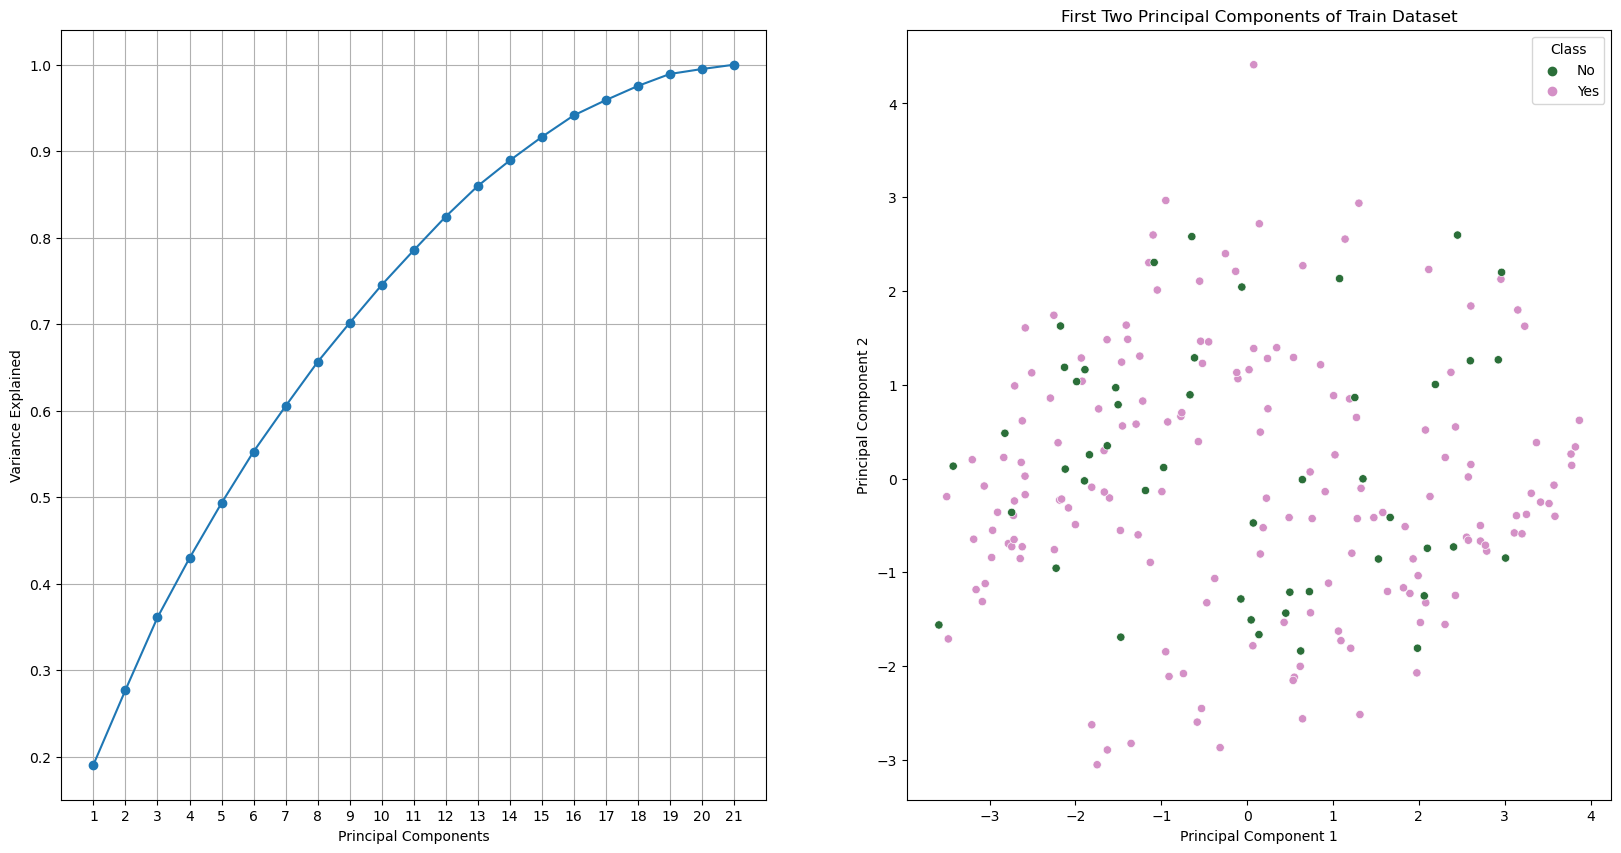

In [41]:
# create a DataFrame with the transformed data
df = pd.DataFrame({'PC1': X_train_pca[:, 0], 'PC2': X_train_pca[:, 1], 'PC3': X_train_pca[:, 2],'PC4': X_train_pca[:, 3],\
                 'PC5': X_train_pca[:, 4], 'PC6': X_train_pca[:, 5],})

# attach class
df["Class"] = dummies_df.output

# set subplots for stack bar plots
fig, axs = plt.subplots(1, 2, figsize=(20,10))

axs[0].plot(pca.explained_variance_ratio_.cumsum(), '-o');
axs[0].set_xticks(range(X_train_pca.shape[1]))
axs[0].set_xticklabels([i + 1 for i in range(X_train_pca.shape[1])]) 
axs[0].set_xlabel('Principal Components')
axs[0].set_ylabel('Variance Explained')
axs[0].grid(visible=True)

# create a scatter plot with different colors for different classes
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Class', palette='cubehelix', ax=axs[1]) 

# plot of PC1 & PC2  
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_title('First Two Principal Components of Train Dataset')

plt.show()

**Visualization on the left provides components and the captured variance of the dataset. On the right is a plot of the first two components to determine the separability of the binary class in the dataset.**

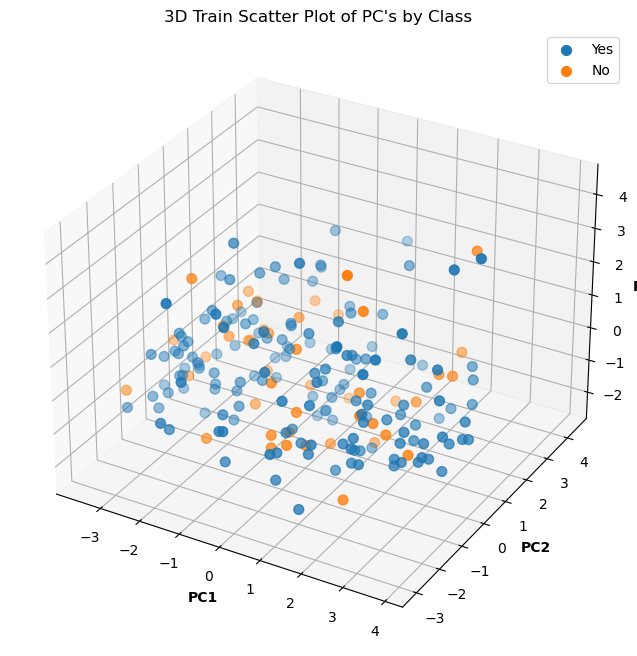

In [42]:
# a DataFrame 'df' with columns 'PC1', 'PC2', 'PC3', and 'Class'
x = df['PC1']
y = df['PC2']
z = df['PC3']
class_labels = df['Class']


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# create a list of unique class labels and corresponding colors
unique_labels = class_labels.unique()
colors = plt.cm.tab10(range(len(unique_labels)))

# scatter plot with different colors for different classes
for label, color in zip(unique_labels, colors):
    mask = class_labels == label
    ax.scatter(x[mask], y[mask], z[mask], label=label, color=color, s=50)

ax.set_title("3D Train Scatter Plot of PC's by Class")
ax.set_xlabel('PC1', fontweight='bold')
ax.set_ylabel('PC2', fontweight='bold')
ax.set_zlabel('PC3', fontweight='bold')

# add a legend to identify the classes
ax.legend()

# plot
plt.show()

**The 3-D plot above visualizes the separability between binary classes.**

#### Quadratic Discriminant Analysis - PCA

In [43]:
# 10 components @ 91.6% 
X_train_pca15 = X_train_pca[:, 0:15]
X_test_pca15 = X_test_pca[:, 0:15]

In [44]:
# create an instance of QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

# instantiate Stratified K-Fold cross-validation takes into account the class distribution
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# evaluate a score by cross-validation
scores = cross_val_score(qda, X=X_train_pca15, y=y_train, scoring='recall', cv=cv, n_jobs=-1)

# print average accuracy score CV with standard deviation
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# fit model
model = qda.fit(X_train_pca15, y_train)

CV accuracy: 0.814 +/- 0.102


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8956521739130435
Specificity:            0.8247422680412371
Precision:              0.8583333333333333
Balanced Accuracy:      0.8601972209771402
F1 Score:               0.8765957446808511




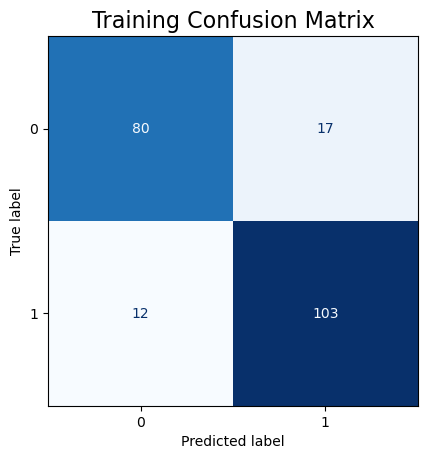



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.86
Specificity:            0.7073170731707317
Precision:              0.7818181818181819
Balanced Accuracy:      0.7836585365853659
F1 Score:               0.819047619047619




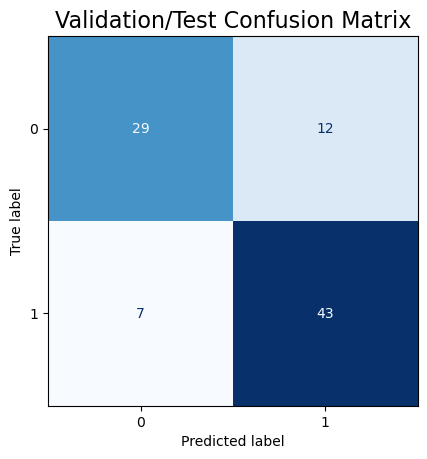

Recall(Sensitivity) Train  \
Algorithm                                                         
QuadraticDiscriminantAnalysis.PCA.15                   0.895652   

                                      Specificity Train  Precision Train  \
Algorithm                                                                  
QuadraticDiscriminantAnalysis.PCA.15           0.824742         0.858333   

                                      Balanced Accuracy Train  F1 Train  \
Algorithm                                                                 
QuadraticDiscriminantAnalysis.PCA.15                 0.860197  0.876596   

                                      Recall(Sensitivity) Validation/Test  \
Algorithm                                                                   
QuadraticDiscriminantAnalysis.PCA.15                                 0.86   

                                      Specificity Validation/Test  \
Algorithm                                                           
QuadraticDiscriminantAnalysis.PCA.15                     0.707317   

                                      Precision Validation/Test  \
Algorithm                                                         
QuadraticDiscriminantAnalysis.PCA.15                   0.781818   

                                      Balanced Accuracy Validation/Test  \
Algorithm                                                                 
QuadraticDiscriminantAnalysis.PCA.15                           0.783659   

                                      F1 Validation/Test  
Algorithm                                                 
QuadraticDiscriminantAnalysis.PCA.15            0.819048

In [45]:
ML = "QuadraticDiscriminantAnalysis.PCA.15"

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_pca15, y_train, X_test_pca15, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

**The Quadratic Discriminant Analysis with 15 PC components has a gap of 7.65% between the training and test accuracy in Quadratic Discriminant Analysis (QDA), which can indicate overfitting.**


In [46]:
# 10 components @ 74.5% 
X_train_pca10 = X_train_pca[:, 0:10]
X_test_pca10 = X_test_pca[:, 0:10]

In [47]:
# create an instance of QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

# instantiate Stratified K-Fold cross-validation takes into account the class distribution
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# evaluate a score by cross-validation
scores = cross_val_score(qda, X=X_train_pca10, y=y_train, scoring='recall', cv=cv, n_jobs=-1)

# print average accuracy score CV with standard deviation
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# fit model
model = qda.fit(X_train_pca10, y_train)

CV accuracy: 0.816 +/- 0.133


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8608695652173913
Specificity:            0.8144329896907216
Precision:              0.8461538461538461
Balanced Accuracy:      0.8376512774540565
F1 Score:               0.8534482758620691




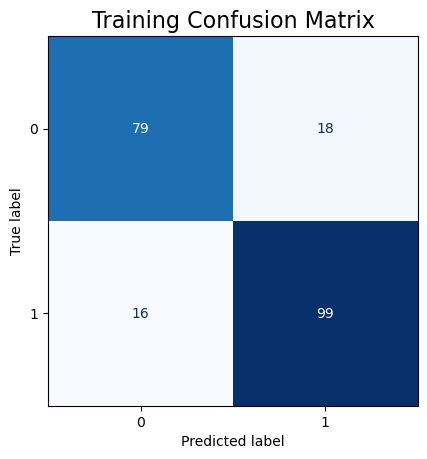



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7317073170731707
Precision:              0.8103448275862069
Balanced Accuracy:      0.8358536585365853
F1 Score:               0.8703703703703703




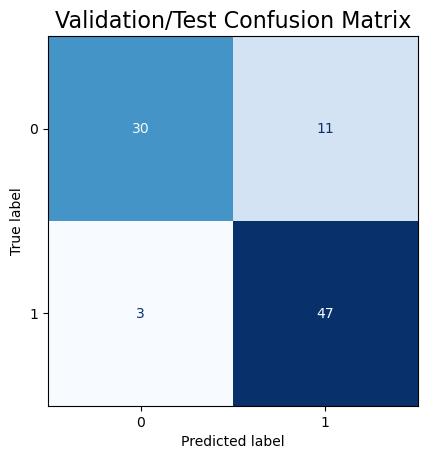

Recall(Sensitivity) Train  \
Algorithm                                                         
QuadraticDiscriminantAnalysis.PCA.10                    0.86087   

                                      Specificity Train  Precision Train  \
Algorithm                                                                  
QuadraticDiscriminantAnalysis.PCA.10           0.814433         0.846154   

                                      Balanced Accuracy Train  F1 Train  \
Algorithm                                                                 
QuadraticDiscriminantAnalysis.PCA.10                 0.837651  0.853448   

                                      Recall(Sensitivity) Validation/Test  \
Algorithm                                                                   
QuadraticDiscriminantAnalysis.PCA.10                                 0.94   

                                      Specificity Validation/Test  \
Algorithm                                                           
QuadraticDiscriminantAnalysis.PCA.10                     0.731707   

                                      Precision Validation/Test  \
Algorithm                                                         
QuadraticDiscriminantAnalysis.PCA.10                   0.810345   

                                      Balanced Accuracy Validation/Test  \
Algorithm                                                                 
QuadraticDiscriminantAnalysis.PCA.10                           0.835854   

                                      F1 Validation/Test  
Algorithm                                                 
QuadraticDiscriminantAnalysis.PCA.10             0.87037

In [48]:
ML = "QuadraticDiscriminantAnalysis.PCA.10"

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_pca10, y_train, X_test_pca10, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

**The Quadratic Discriminant Analysis with 10 PC components is providing a good result.**

**Quadratic Discriminant Analysis (QDA) can capture more complex relationships between features within each class because it doesn't assume that all classes share the same covariance matrix. This can be particularly beneficial when dealing with datasets where the classes have significantly different variances or when the relationship between features and classes is nonlinear.**

#### Logistic Regression - PCA: 15 PCs

In [49]:
# 15 components @ 91.6%
X_train_pca15 = X_train_pca[:, 0:15]
X_test_pca15 = X_test_pca[:, 0:15]

In [50]:
# define the hyperparameter grid to search
parameters = dict(
C = np.linspace(0.15, 2, 15),
max_iter = [75, 100, 125, 175, 200, 250]
)
# Base Model
lr_param = {'random_state': RANDOM_STATE}

# instantiate SVC
model = LogisticRegression(**lr_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train_pca15, y_train)

CV accuracy: 0.868 +/- 0.090


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8695652173913043
Specificity:            0.8350515463917526
Precision:              0.8620689655172413
Balanced Accuracy:      0.8523083818915285
F1 Score:               0.8658008658008657




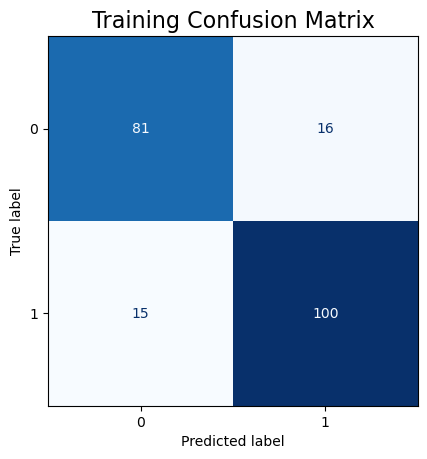



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.92
Specificity:            0.7560975609756098
Precision:              0.8214285714285714
Balanced Accuracy:      0.838048780487805
F1 Score:               0.8679245283018867




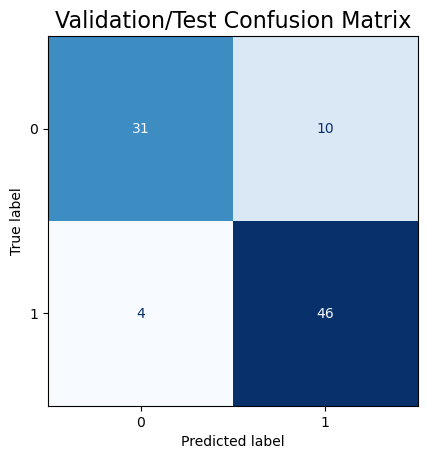

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                                
LogisticRegression.PCA15                   0.869565           0.835052   

                          Precision Train  Balanced Accuracy Train  F1 Train  \
Algorithm                                                                      
LogisticRegression.PCA15         0.862069                 0.852308  0.865801   

                          Recall(Sensitivity) Validation/Test  \
Algorithm                                                       
LogisticRegression.PCA15                                 0.92   

                          Specificity Validation/Test  \
Algorithm                                               
LogisticRegression.PCA15                     0.756098   

                          Precision Validation/Test  \
Algorithm                                             
LogisticRegression.PCA15                   0.821429   

                          Balanced Accuracy Validation/Test  \
Algorithm                                                     
LogisticRegression.PCA15                           0.838049   

                          F1 Validation/Test  
Algorithm                                     
LogisticRegression.PCA15            0.867925

In [51]:
ML = "LogisticRegression.PCA15"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_pca15, y_train, X_test_pca15, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:,2:]

#### XGB Classifier - PCA: 15 PCs

In [52]:
# define the hyperparameter grid to search
parameters = {
    "learning_rate": [0.01, 0.02, 0.03],  # learning rate
    "max_depth": [2, 3, 4], # control over-fitting as higher depth will allow the model to learn relations very specific
    "gamma": [0, 0.6, 1], # the minimum loss reduction required to make a split
    'subsample': [0.7, 0.8], # fraction of data used for each tree
    'min_child_weight': [2, 3, 4],
}

# define default XGB Classifier parameters 
xgb_param = {
    'disable_default_eval_metric':  'true',
    'tree_method':                  'hist', # constructs trees using a histogram-based & memory-efficient and fast
    'random_state': RANDOM_STATE,
}

# instantiate XGB Classifier
model = xgb.XGBClassifier(**xgb_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train_pca15, y_train)

CV accuracy: 0.887 +/- 0.095


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8956521739130435
Specificity:            0.8144329896907216
Precision:              0.8512396694214877
Balanced Accuracy:      0.8550425818018825
F1 Score:               0.8728813559322034




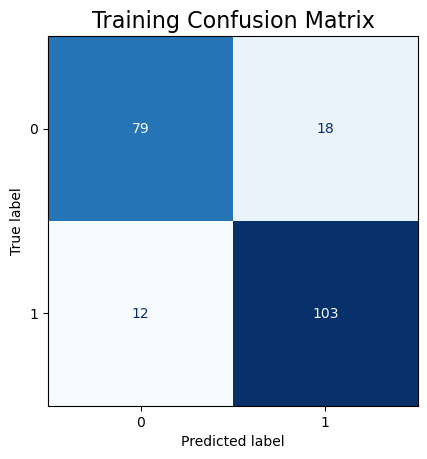



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7804878048780488
Precision:              0.8392857142857143
Balanced Accuracy:      0.8602439024390244
F1 Score:               0.8867924528301886




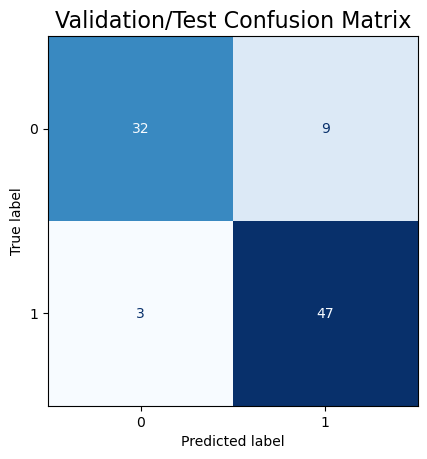

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                           
XGBClassifier.PCA15                   0.895652           0.814433   

                     Precision Train  Balanced Accuracy Train  F1 Train  \
Algorithm                                                                 
XGBClassifier.PCA15          0.85124                 0.855043  0.872881   

                     Recall(Sensitivity) Validation/Test  \
Algorithm                                                  
XGBClassifier.PCA15                                 0.94   

                     Specificity Validation/Test  Precision Validation/Test  \
Algorithm                                                                     
XGBClassifier.PCA15                     0.780488                   0.839286   

                     Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                                   
XGBClassifier.PCA15                           0.860244            0.886792

In [53]:
ML = "XGBClassifier.PCA15"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_pca15, y_train, X_test_pca15, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
# plot_feature_importance(model, clean_df)

# display
df_.iloc[:, 2:]

**We use fifteen PC components between the two models, with 91.6% of the explained variance from the dataset. Both algorithms perform well, but it's clear that the `XGBoost` is superior at generalizing an unseen dataset from the model performance below. The Quadratic Discriminant Analysis is fascinating since it only uses nine PC components with the same `Recall/Sensitivity` as `XGBoost` rather than 15 PC components.**

In [54]:
classify_performance_df.iloc[:,2:][classify_performance_df.index.str.contains("PCA") \
                                  ].sort_values(by=['Recall(Sensitivity) Validation/Test', 'F1 Validation/Test'], ascending=False)

Recall(Sensitivity) Train  \
Algorithm                                                         
XGBClassifier.PCA15                                    0.895652   
QuadraticDiscriminantAnalysis.PCA.10                   0.860870   
LogisticRegression.PCA15                               0.869565   
QuadraticDiscriminantAnalysis.PCA.15                   0.895652   

                                      Specificity Train  Precision Train  \
Algorithm                                                                  
XGBClassifier.PCA15                            0.814433         0.851240   
QuadraticDiscriminantAnalysis.PCA.10           0.814433         0.846154   
LogisticRegression.PCA15                       0.835052         0.862069   
QuadraticDiscriminantAnalysis.PCA.15           0.824742         0.858333   

                                      Balanced Accuracy Train  F1 Train  \
Algorithm                                                                 
XGBClassifier.PCA15                                  0.855043  0.872881   
QuadraticDiscriminantAnalysis.PCA.10                 0.837651  0.853448   
LogisticRegression.PCA15                             0.852308  0.865801   
QuadraticDiscriminantAnalysis.PCA.15                 0.860197  0.876596   

                                      Recall(Sensitivity) Validation/Test  \
Algorithm                                                                   
XGBClassifier.PCA15                                                  0.94   
QuadraticDiscriminantAnalysis.PCA.10                                 0.94   
LogisticRegression.PCA15                                             0.92   
QuadraticDiscriminantAnalysis.PCA.15                                 0.86   

                                      Specificity Validation/Test  \
Algorithm                                                           
XGBClassifier.PCA15                                      0.780488   
QuadraticDiscriminantAnalysis.PCA.10                     0.731707   
LogisticRegression.PCA15                                 0.756098   
QuadraticDiscriminantAnalysis.PCA.15                     0.707317   

                                      Precision Validation/Test  \
Algorithm                                                         
XGBClassifier.PCA15                                    0.839286   
QuadraticDiscriminantAnalysis.PCA.10                   0.810345   
LogisticRegression.PCA15                               0.821429   
QuadraticDiscriminantAnalysis.PCA.15                   0.781818   

                                      Balanced Accuracy Validation/Test  \
Algorithm                                                                 
XGBClassifier.PCA15                                            0.860244   
QuadraticDiscriminantAnalysis.PCA.10                           0.835854   
LogisticRegression.PCA15                                       0.838049   
QuadraticDiscriminantAnalysis.PCA.15                           0.783659   

                                      F1 Validation/Test  
Algorithm                                                 
XGBClassifier.PCA15                             0.886792  
QuadraticDiscriminantAnalysis.PCA.10            0.870370  
LogisticRegression.PCA15                        0.867925  
QuadraticDiscriminantAnalysis.PCA.15            0.819048

#### Logistic Regression - LDA

In [55]:
# instantiate LDA
lda = LinearDiscriminantAnalysis(n_components = None)

# fit LDA
lda.fit(X_train, y_train)

# transform train & test
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [56]:
# define the hyperparameter grid to search
parameters = dict(
C = np.linspace(0.15, 2, 15),
max_iter = [75, 100, 125, 175, 200, 250]
)
# Base Model
lr_param = {'random_state': RANDOM_STATE}

# instantiate SVC
model = LogisticRegression(**lr_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train_lda, y_train)

CV accuracy: 0.914 +/- 0.085


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9130434782608695
Specificity:            0.8144329896907216
Precision:              0.8536585365853658
Balanced Accuracy:      0.8637382339757955
F1 Score:               0.8823529411764706




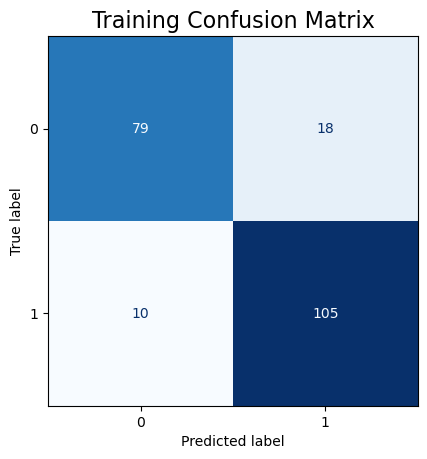



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7560975609756098
Precision:              0.8245614035087719
Balanced Accuracy:      0.8480487804878049
F1 Score:               0.8785046728971964




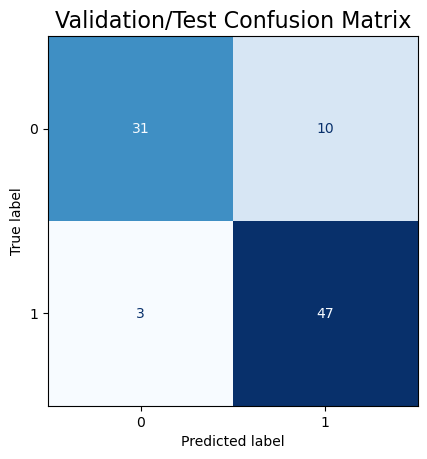

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                              
LogisticRegression.LDA                   0.913043           0.814433   

                        Precision Train  Balanced Accuracy Train  F1 Train  \
Algorithm                                                                    
LogisticRegression.LDA         0.853659                 0.863738  0.882353   

                        Recall(Sensitivity) Validation/Test  \
Algorithm                                                     
LogisticRegression.LDA                                 0.94   

                        Specificity Validation/Test  \
Algorithm                                             
LogisticRegression.LDA                     0.756098   

                        Precision Validation/Test  \
Algorithm                                           
LogisticRegression.LDA                   0.824561   

                        Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                                      
LogisticRegression.LDA                           0.848049            0.878505

In [57]:
ML = "LogisticRegression.LDA"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_lda, y_train, X_test_lda, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:,2:]

#### AdaBoost Classifier - LDA

In [58]:
# number of trees in the forest (default (50))
n_estimators = list(np.linspace(10, 1000, num=5, dtype=np.intc))

# learning rate default(1)
learning_rate = [.0001, .001, .01, 1]

# hyper-parameters
parameters = dict(
    n_estimators = n_estimators,
    learning_rate = learning_rate
)

# Base Model
ada_param = {'random_state': RANDOM_STATE}

# instantiate AdaBoost Classifier
model = AdaBoostClassifier(**ada_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train_lda, y_train)

CV accuracy: 0.888 +/- 0.086


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9130434782608695
Specificity:            0.845360824742268
Precision:              0.875
Balanced Accuracy:      0.8792021515015688
F1 Score:               0.8936170212765957




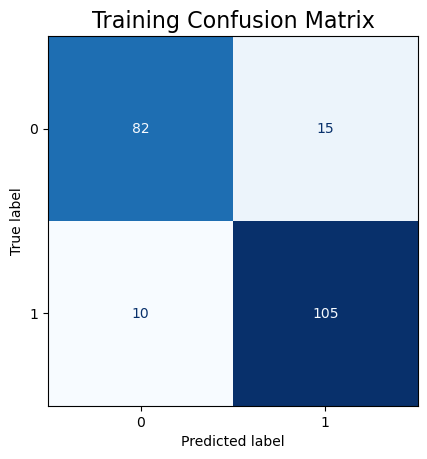



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.92
Specificity:            0.7560975609756098
Precision:              0.8214285714285714
Balanced Accuracy:      0.838048780487805
F1 Score:               0.8679245283018867




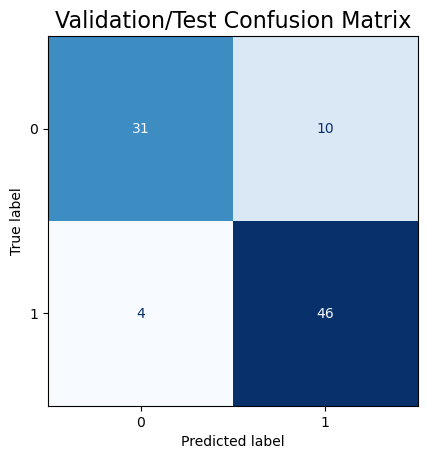

Recall(Sensitivity) Train  Specificity Train  Precision Train  \
Algorithm                                                                     
AdaBoost.LDA                   0.913043           0.845361            0.875   

              Balanced Accuracy Train  F1 Train  \
Algorithm                                         
AdaBoost.LDA                 0.879202  0.893617   

              Recall(Sensitivity) Validation/Test  \
Algorithm                                           
AdaBoost.LDA                                 0.92   

              Specificity Validation/Test  Precision Validation/Test  \
Algorithm                                                              
AdaBoost.LDA                     0.756098                   0.821429   

              Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                            
AdaBoost.LDA                           0.838049            0.867925

In [59]:
# initialize
ML = "AdaBoost.LDA"

model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_lda, y_train, X_test_lda, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
# plot_feature_importance(model, clean_df)

df_.iloc[:,2:]

#### SVC - LDA

In [60]:
# define the hyperparameter grid to search
parameters = dict(
C = [5, 6, 7, 8, 9],
gamma = [0.001, 0.002, 0.01]
)
# Base Model
svc_param = {'random_state': RANDOM_STATE}

# instantiate SVC
model = SVC(**svc_param)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(model, parameters, X_train_lda, y_train)

CV accuracy: 0.931 +/- 0.063


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9304347826086956
Specificity:            0.8144329896907216
Precision:              0.856
Balanced Accuracy:      0.8724338861497086
F1 Score:               0.8916666666666667




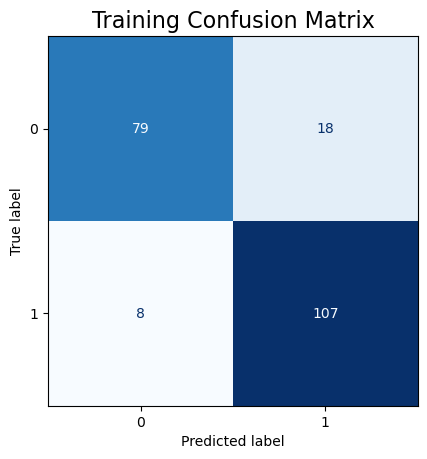



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7073170731707317
Precision:              0.7966101694915254
Balanced Accuracy:      0.8236585365853658
F1 Score:               0.8623853211009174




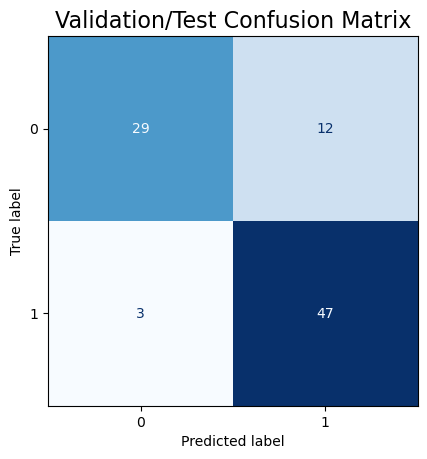

Recall(Sensitivity) Train  Specificity Train  Precision Train  \
Algorithm                                                                  
SVC.LDA                     0.930435           0.814433            0.856   

           Balanced Accuracy Train  F1 Train  \
Algorithm                                      
SVC.LDA                   0.872434  0.891667   

           Recall(Sensitivity) Validation/Test  Specificity Validation/Test  \
Algorithm                                                                     
SVC.LDA                                   0.94                     0.707317   

           Precision Validation/Test  Balanced Accuracy Validation/Test  \
Algorithm                                                                 
SVC.LDA                      0.79661                           0.823659   

           F1 Validation/Test  
Algorithm                      
SVC.LDA              0.862385

In [61]:
ML = "SVC.LDA"
model = fit.best_estimator_

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train_lda, y_train, X_test_lda, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

**Linear Discriminant Analysis (LDA) is a classification and dimensionality reduction technique that we are using as a dimensionality reduction for our machine learning. The models listed below were used with LDA data to classify, and `Logistic Regression` performs the best according to the `Recall/Sensitivity` and `F1` scoring below.**

In [62]:
classify_performance_df.iloc[:,2:][classify_performance_df.index.str.contains("LDA") \
                                  ].sort_values(by=['Recall(Sensitivity) Validation/Test', 'F1 Validation/Test'], ascending=False)

Recall(Sensitivity) Train  Specificity Train  \
Algorithm                                                              
LogisticRegression.LDA                   0.913043           0.814433   
SVC.LDA                                  0.930435           0.814433   
AdaBoost.LDA                             0.913043           0.845361   

                        Precision Train  Balanced Accuracy Train  F1 Train  \
Algorithm                                                                    
LogisticRegression.LDA         0.853659                 0.863738  0.882353   
SVC.LDA                        0.856000                 0.872434  0.891667   
AdaBoost.LDA                   0.875000                 0.879202  0.893617   

                        Recall(Sensitivity) Validation/Test  \
Algorithm                                                     
LogisticRegression.LDA                                 0.94   
SVC.LDA                                                0.94   
AdaBoost.LDA                                           0.92   

                        Specificity Validation/Test  \
Algorithm                                             
LogisticRegression.LDA                     0.756098   
SVC.LDA                                    0.707317   
AdaBoost.LDA                               0.756098   

                        Precision Validation/Test  \
Algorithm                                           
LogisticRegression.LDA                   0.824561   
SVC.LDA                                  0.796610   
AdaBoost.LDA                             0.821429   

                        Balanced Accuracy Validation/Test  F1 Validation/Test  
Algorithm                                                                      
LogisticRegression.LDA                           0.848049            0.878505  
SVC.LDA                                          0.823659            0.862385  
AdaBoost.LDA                                     0.838049            0.867925

### Stacking AdaBoost & LogisticRegression

In [76]:
# base estimator
estimators = [
     ('LR',  LogisticRegression()),
     ('SVC', SVC()),
     ('XGB', xgb.XGBClassifier())
      ]

# instantiate Stratified K-Fold cross-validation takes into account the class distribution
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    
# stacking ML
clf = StackingClassifier(estimators=estimators, final_estimator=LinearDiscriminantAnalysis(), cv=cv, n_jobs = -1) 

# CV with grid search for Hyper-Parameter tuning
model = clf.fit(X_train, y_train)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9217391304347826
Specificity:            0.8350515463917526
Precision:              0.8688524590163934
Balanced Accuracy:      0.8783953384132677
F1 Score:               0.8945147679324895




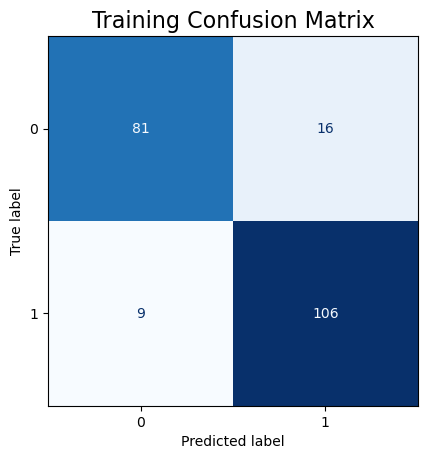



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7560975609756098
Precision:              0.8245614035087719
Balanced Accuracy:      0.8480487804878049
F1 Score:               0.8785046728971964




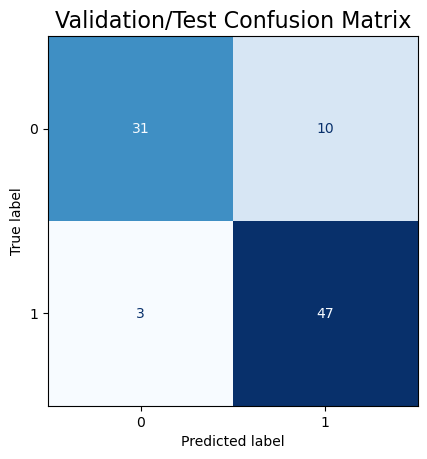

Recall(Sensitivity) Train  \
Algorithm                                                                       
Stacking (LR/SVC/XGB with Final Estimator As Li...                   0.921739   

                                                    Specificity Train  \
Algorithm                                                               
Stacking (LR/SVC/XGB with Final Estimator As Li...           0.835052   

                                                    Precision Train  \
Algorithm                                                             
Stacking (LR/SVC/XGB with Final Estimator As Li...         0.868852   

                                                    Balanced Accuracy Train  \
Algorithm                                                                     
Stacking (LR/SVC/XGB with Final Estimator As Li...                 0.878395   

                                                    F1 Train  \
Algorithm                                                      
Stacking (LR/SVC/XGB with Final Estimator As Li...  0.894515   

                                                    Recall(Sensitivity) Validation/Test  \
Algorithm                                                                                 
Stacking (LR/SVC/XGB with Final Estimator As Li...                                 0.94   

                                                    Specificity Validation/Test  \
Algorithm                                                                         
Stacking (LR/SVC/XGB with Final Estimator As Li...                     0.756098   

                                                    Precision Validation/Test  \
Algorithm                                                                       
Stacking (LR/SVC/XGB with Final Estimator As Li...                   0.824561   

                                                    Balanced Accuracy Validation/Test  \
Algorithm                                                                               
Stacking (LR/SVC/XGB with Final Estimator As Li...                           0.848049   

                                                    F1 Validation/Test  
Algorithm                                                               
Stacking (LR/SVC/XGB with Final Estimator As Li...            0.878505

In [77]:
# initialize
ML = "Stacking (LR/SVC/XGB with Final Estimator As LinearDiscriminantAnalysis)"

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
# plot_feature_importance(model, clean_df)

df_.iloc[:,2:]

In [65]:
# number of n_estimators
n_estimators = list(np.linspace(5, 1000, num=5, dtype=np.intc))

# hyper-parameters
parameters = dict(
    n_estimators = n_estimators
)

# create Ada Boost classifier as the base estimator (deal with overfitting)
base_classifier = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)

# create a BaggingClassifier with the Ada Boost as the base classifier
bagging_classifier = BaggingClassifier(base_classifier, n_jobs = -1, random_state=RANDOM_STATE)

fit = bagging_classifier.fit(X_train, y_train)

# CV with grid search for Hyper-Parameter tuning
fit = stratified_grid(bagging_classifier, parameters, X_train, y_train)

CV accuracy: 0.842 +/- 0.093


***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8782608695652174
Specificity:            0.8556701030927835
Precision:              0.8782608695652174
Balanced Accuracy:      0.8669654863290004
F1 Score:               0.8782608695652175




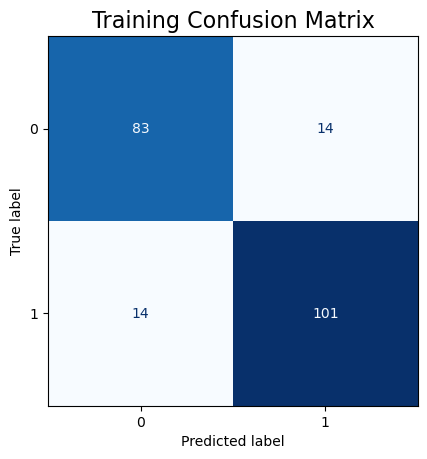



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.94
Specificity:            0.7804878048780488
Precision:              0.8392857142857143
Balanced Accuracy:      0.8602439024390244
F1 Score:               0.8867924528301886




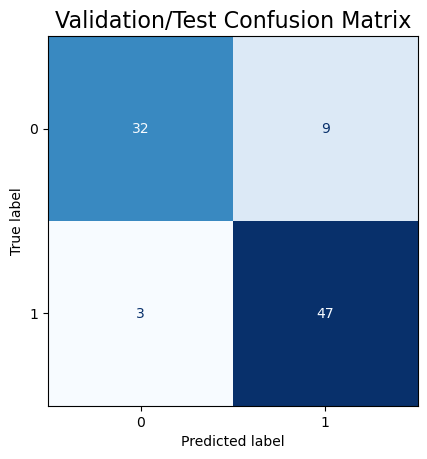

Recall(Sensitivity) Train  \
Algorithm                                                         
Decision Tree with BaggingClassifier                   0.878261   

                                      Specificity Train  Precision Train  \
Algorithm                                                                  
Decision Tree with BaggingClassifier            0.85567         0.878261   

                                      Balanced Accuracy Train  F1 Train  \
Algorithm                                                                 
Decision Tree with BaggingClassifier                 0.866965  0.878261   

                                      Recall(Sensitivity) Validation/Test  \
Algorithm                                                                   
Decision Tree with BaggingClassifier                                 0.94   

                                      Specificity Validation/Test  \
Algorithm                                                           
Decision Tree with BaggingClassifier                     0.780488   

                                      Precision Validation/Test  \
Algorithm                                                         
Decision Tree with BaggingClassifier                   0.839286   

                                      Balanced Accuracy Validation/Test  \
Algorithm                                                                 
Decision Tree with BaggingClassifier                           0.860244   

                                      F1 Validation/Test  
Algorithm                                                 
Decision Tree with BaggingClassifier            0.886792

In [66]:
# initialize
ML = "Decision Tree with BaggingClassifier"
model = fit

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model, X_train, y_train, X_test, y_test)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
# plot_feature_importance(model, clean_df)

df_.iloc[:,2:]

**Utilization of Stacking Algorthims on this dataset did not provide a better solution since most of the classifiers performed well. This exercise would benefit from a more challenging dataset but was a valuable learning experience for our final project.**

#### Dispaly Performance

In [78]:
classify_performance_df.iloc[:,2:].sort_values(by=['Recall(Sensitivity) Validation/Test', 'F1 Validation/Test'], ascending=False)
# delete 
# classify_performance_df = classify_performance_df[classify_performance_df.index != 'Stacking.LDA (AdaBoost & LogisticRegression)']

Recall(Sensitivity) Train  \
Algorithm                                                                       
XGBClassifier                                                        0.921739   
RandomForestClassifier                                               0.921739   
Decision Tree with BaggingClassifier                                 0.878261   
XGBClassifier.PCA15                                                  0.895652   
Stacking (LR/SVC/XGB with Final Estimator As Li...                   0.921739   
LogisticRegression.LDA                                               0.913043   
QuadraticDiscriminantAnalysis.PCA.10                                 0.860870   
SVC                                                                  0.895652   
LogisticRegression                                                   0.913043   
SVC.LDA                                                              0.930435   
LinearDiscriminantAnalysis                                           0.930435   
AdaBoost.LDA                                                         0.913043   
LogisticRegression.PCA15                                             0.869565   
QuadraticDiscriminantAnalysis.PCA.15                                 0.895652   

                                                    Specificity Train  \
Algorithm                                                               
XGBClassifier                                                0.824742   
RandomForestClassifier                                       0.804124   
Decision Tree with BaggingClassifier                         0.855670   
XGBClassifier.PCA15                                          0.814433   
Stacking (LR/SVC/XGB with Final Estimator As Li...           0.835052   
LogisticRegression.LDA                                       0.814433   
QuadraticDiscriminantAnalysis.PCA.10                         0.814433   
SVC                                                          0.814433   
LogisticRegression                                           0.824742   
SVC.LDA                                                      0.814433   
LinearDiscriminantAnalysis                                   0.814433   
AdaBoost.LDA                                                 0.845361   
LogisticRegression.PCA15                                     0.835052   
QuadraticDiscriminantAnalysis.PCA.15                         0.824742   

                                                    Precision Train  \
Algorithm                                                             
XGBClassifier                                              0.861789   
RandomForestClassifier                                     0.848000   
Decision Tree with BaggingClassifier                       0.878261   
XGBClassifier.PCA15                                        0.851240   
Stacking (LR/SVC/XGB with Final Estimator As Li...         0.868852   
LogisticRegression.LDA                                     0.853659   
QuadraticDiscriminantAnalysis.PCA.10                       0.846154   
SVC                                                        0.851240   
LogisticRegression                                         0.860656   
SVC.LDA                                                    0.856000   
LinearDiscriminantAnalysis                                 0.856000   
AdaBoost.LDA                                               0.875000   
LogisticRegression.PCA15                                   0.862069   
QuadraticDiscriminantAnalysis.PCA.15                       0.858333   

                                                    Balanced Accuracy Train  \
Algorithm                                                                     
XGBClassifier                                                      0.873241   
RandomForestClassifier                                             0.862931   
Decision Tree with BaggingClassifier                               0.866965   
XGBClassifier.PCA15                                   

**We experimented with multiple machine learning models and used PCA and LDA dimensionality reduction techniques in our exercise. Also, we utilized LDA to classify, and our results were excellent, with a Recall/Sensitivity of 94% and an F1 score of 86.2%. While Stacking Algrothrm using base estimators of Linear Regression, Support Vector Classfier, and XGBoost with final estimators as LDA and without tuning each classfier, we achieved a Recall/Sensitivity of 94% with an F1 score of 87.9%. We tried replicating Random Forest using a Decision Tree with a Bagging classifier, and the Decision Tree with Bagging did achieve a better balance between precision and recall. Most surprising was that XGBoost, using 15 PC components, surpassed the top two classifiers in Recall/Sensitivity.**

**To conclude, the model we felt was XGBoost was a better model even though tied with Random Forest due to the speed of training, and additional fine-tuning may have improved our model. Still, we can ignore the Decision Tree with BaggingClassifier due to achieving a better balance between precision and recall. Our comprehensive analysis provides valuable insights into the strengths and weaknesses of various models and techniques for our dataset.**